In [1]:
import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Introduction


This notebook is meant to accompany the paper _Multi-parameter optimization and model extrapolation using antimalarial drug screening data_ - currently in preparation - so that all results can easily be replicated.

Contents are as follows:
- Data discussion
- Digression on Tanimoto distance
- Bias correction
- MPO optimization


## Data discussion

We have extracted antimalarial data from ChEMBL. We firstly focus on the agreement for repeated measurements using different assays, and then we will analyse the **TCAMS dataset**, which is the largest screening effort available performed under controlled experimental conditions. 

We have three main datasets.  Firstly, the one available here on the ChEMBL gitbook

A. https://chembl.gitbook.io/chembl-ntd/downloads/deposited-set-1-gsk-tcams-dataset-20th-may-2010

We will refer to this henceforth as the **TCAMS dataset**. The pickled file containing this data set is chembl\_tcams.pkl. The code to generate this file is in utils.py (the data are just downloaded as csv, are then standardised, fingerprints added, and are then pickled).

We also have:

B. The ChEMBL data associated to the malaria assays (downloaded from the webclient, code in Appendix). The pickled file containing this data set is malaria\_chembl\.pickle

We'll refer to this as the **ChEMBL dataset**.  In this section we'll talk about the advantages and disadvantages of each dataset, and how we can use them together (in particular, how to enrich with inactives from ChEMBL the TCAMS dataset).

Finally we have two quite different datasets - which we will use for the purposes of sanity checking the datasets above, and testing - insofar as we can - the predictions we make from them:

C.  A list of 7 well-known malaria drugs.

D.  Roughly 7.5 million commercially available compounds from Molport.
 
We will not be adding the Molport data (we don't have permission, and it is too big anyway to fit onto git). Thus the final parts of this work won't be reproducible from git.

# 2. Understanding the antimalarial screening data publicly available

We first have a look at all the antimalarial data in ChEMBL:

In [2]:
import pickle
with open('malaria_chembl.pickle', 'rb') as handle:
    b = pickle.load(handle)
a=[]
for i in b:
    a.append(i['assay_description'])
from collections import Counter
freq = Counter(a)

By looking at how many datapoints are reported for each assay in ChEMBL, we observe high variability across screening efforts: 

In [144]:
for i in freq:
    print("{}  {}\n".format(i, freq[i]))

OSM: Percent inhibition of Plasmodium falciparum 3D7 growth at 40 uM. Avery Group Griffith.  5

OSM: CSIR assay 3D7: Compounds were tested for inhibition of Plasmodium falciparum growth using a SYBR green I fluorescence based assay.  3

ST_JUDE: Cytotoxicity against Plasmodium falciparum W2  172

OSM: Inhibition of Plasmodium falciparum K1 growth. IC50 values determined from 21 point dose response curves. Avery Group Griffith.  9

WHO-TDR: Malaria  740

HARVARD: Inhibition of blood stage Plasmodium falciparum 3D7 infection  13

ST_JUDE: Cytotoxicity against Plasmodium falciparum SB-A6  172

MMV: Modified 3H-Hyoxanthine uptake assay; 1% O2, 5% CO2 in N2.  57

OSM: Inhibition of Plasmodium falciparum 3D7 growth using a SYBR green I fluorescence based assay. GSK Tres Cantos.  27

OSM: Inhibition of Plasmodium falciparum 3D7 growth using a SYBR green I fluorescence based assay. Dose response curves were generated comprising of 8 points using a 2-fold serial dilution for the maximum final c

Next, we look for compounds whose activity has been measured in at least 20 experiments:

In [16]:
ll=[]
for i in b:                               
    ll.append(i['molecule_chembl_id'])
co=set(ll)

comps_more_than_20_measurements=[]
for comp in co:                   
    if ll.count(comp) >20:        
        print("{} {}".format(comp, ll.count(comp)))
        comps_more_than_20_measurements.append(comp)


CHEMBL589946 25
CHEMBL600305 22
CHEMBL586704 23
CHEMBL588481 22
CHEMBL537071 21
CHEMBL547476 27
CHEMBL531222 25
CHEMBL525826 23
CHEMBL589205 25
CHEMBL584240 28
CHEMBL547266 22
CHEMBL591641 24
CHEMBL525106 21
CHEMBL529732 23
CHEMBL532141 25
CHEMBL524973 26
CHEMBL125044 21
CHEMBL532597 21
CHEMBL524784 24
CHEMBL598369 22
CHEMBL529773 23
CHEMBL546994 24
CHEMBL586344 25
CHEMBL533563 21
CHEMBL549210 29
CHEMBL261693 23
CHEMBL580580 23
CHEMBL585264 23
CHEMBL580353 23
CHEMBL587288 22
CHEMBL589422 24
CHEMBL591887 24
CHEMBL546799 21
CHEMBL601580 23
CHEMBL590212 25
CHEMBL586031 23
CHEMBL586033 21
CHEMBL533917 24
CHEMBL590888 22
CHEMBL529640 23
CHEMBL532879 22
CHEMBL470514 25
CHEMBL597248 21
CHEMBL528734 21
CHEMBL529919 21
CHEMBL587022 24
CHEMBL597855 24
CHEMBL598279 22
CHEMBL601348 21
CHEMBL530531 21
CHEMBL581175 25
CHEMBL546162 25
CHEMBL601771 22
CHEMBL587989 23
CHEMBL1615697 22
CHEMBL526981 25
CHEMBL605281 29
CHEMBL577011 21
CHEMBL106525 30


KeyboardInterrupt: 

How do measurements for the same compound vary across assays?
We get the measurements first:

In [30]:
dict_multiple_measurements={}
for comp in b:
    if comp['molecule_chembl_id'] in comps_more_than_20_measurements:
        comp_now=comp['molecule_chembl_id']
        if dict_multiple_measurements.has_key(comp_now):
            dict_multiple_measurements[comp_now].append(comp)
        else:
            dict_multiple_measurements[comp_now]=[]
            dict_multiple_measurements[comp_now].append(comp)

In [36]:
for comp in comps_more_than_20_measurements:
    now = dict_multiple_measurements[comp]
    print("Compound {}".format(comp))
    for i,x in enumerate(now):
        print("{} {} {} {} {}".format(now[i]["pchembl_value"], now[i]["standard_units"], now[i]["published_relation"], now[i]["standard_type"], now[i]["published_value"]))
    print("\n\n")

Compound CHEMBL589946
None nM None EC50 0.4389
None nM None EC50 2.4017
None nM None EC50 0.992
None nM None EC50 1.1474
None nM None EC50 1.6762
None nM None EC50 4.3032
None nM None EC50 2.2549
None nM None EC50 1.3455
None nM None EC50 4.0982
None % = Inhibition 96
6.34 nM = EC50 456
5.9 nM = EC50 1260
None - = Ratio 0.9295774647887325
None % = Inhibition -4.617281941548253
None % = Inhibition 4.923566896064017
None % = Inhibition -2.8448514282241213
None % = Growth Inhibition 37.0308
None nM > IC50 2.5
None nM > IC50 1
None nM > IC50 1
None nM > IC50 1
None nM > IC50 2.5
None nM > IC50 1
None nM > IC50 1
5.97 nM = IC50 1076



Compound CHEMBL600305
5.75 nM = EC50 1.795
5.61 nM = EC50 2.464
None None None Activity None
None % = Inhibition 96
6.65 nM = EC50 224
6.75 nM = EC50 179
None - = Ratio 0.8421052631578947
None % = Inhibition -19.70573710363082
None % = Inhibition 21.793938337110706
None % = Inhibition -9.11214139138309
None nM > IC50 1
None nM > IC50 1
None nM > IC50 1
None n

Compound CHEMBL597248
7.03 nM = EC50 0.0934
6.8 nM = EC50 0.1579
6.82 nM = IC50 0.1528
None None None Activity None
None um = Schizont size 29.85
None % = Inhibition 95
6.11 nM = EC50 776
None - = Ratio 1
6.37 nM = IC50 0.430162
None % = Inhibition -4.491224789823413
None % = Inhibition -50.61291059873643
None % = Inhibition -29.24603096225088
None % = Growth Inhibition 12.3006
None nM > IC50 1
None nM > IC50 1
None nM > IC50 2.5
None nM > IC50 1
None nM > IC50 1
None nM > IC50 2.5
None nM > IC50 1
6.05 nM = IC50 897.4



Compound CHEMBL528734
6.16 nM = XC50 0.69222
None % = Inhibition 82
None % = Inhibition 90
None % = Inhibition 0
5.11 nM = EC50 7.72
5.14 nM = EC50 7.23
None None None Activity None
None % = Inhibition 77
None - = Ratio 1.0517241379310345
None % = Inhibition 36.59655064639631
None % = Inhibition 33.73327461596418
None % = Inhibition -30.520681926112093
None % = Growth Inhibition 21.2738
None nM > IC50 1
None nM > IC50 2.5
None nM > IC50 1
None nM > IC50 2.5
None nM > 

We observe substantial variability across measurements, readouts, standard units and published relationships, with many measurements only providing a lower or upper bound for activity. Hence, we proceed to focus on the antimalarial screening data set "TCAMS".

# The Tres Cantos Antimalarial Set (TCAMS) from GSK

The GSK TCAMS screening data, which encompasses 13533 compounds, are reported for 4 assays:

1. GSK_TCMDC: Inhibition of Plasmodium falciparum Dd2 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM 

2. GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM  

3. GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 LDH activity, using an LDH reporter assay. Test compounds present at 2uM  

4. GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole erythrocytes, using parasite LDH activity as an index of growth.  

In [65]:
TCAMS_from_ChEMBL = [x for x in b if x["assay_description"] == "GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole erythrocytes, using parasite LDH activity as an index of growth."]
print(len(TCAMS_from_ChEMBL))

# the following sets report % of inhibition and not pChEMBL values
TCAMS_from_ChEMBL_2uM = [x for x in b if x["assay_description"] == "GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 LDH activity, using an LDH reporter assay. Test compounds present at 2uM"]
print(len(TCAMS_from_ChEMBL))

TCAMS_from_ChEMBL_parasite_LDH_2uM = [x for x in b if x["assay_description"] == "GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM"]
print(len(TCAMS_from_ChEMBL))

TCAMS_from_ChEMBL_Dd2_LDH_2uM = [x for x in b if x["assay_description"] == "GSK_TCMDC: Inhibition of Plasmodium falciparum Dd2 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM"]
print(len(TCAMS_from_ChEMBL))

13533
13533
13533
13533


The GSK screening data are described in a 2010 Nature publication. The abstract reads as follows:

*"Malaria is a devastating infection caused by protozoa of the genus Plasmodium. Drug resistance is widespread, no new chemical class of antimalarials has been introduced into clinical practice since 1996 and there is a recent rise of parasite strains with reduced sensitivity to the newest drugs. We screened nearly 2 million compounds in GlaxoSmithKline's chemical library for inhibitors of P. falciparum, **of which 13,533 were confirmed to inhibit parasite growth by at least 80% at 2 microM concentration**. More than 8,000 also showed potent activity against the multidrug resistant strain Dd2. Most (82%) compounds originate from internal company projects and are new to the malaria community. Analyses using historic assay data suggest several novel mechanisms of antimalarial action, such as inhibition of protein kinases and host-pathogen interaction related targets. Chemical structures and associated data are hereby made public to encourage additional drug lead identification efforts and further research into this disease."*

The data in TCAMS_from_ChEMBL correspond to the percentage of inhibition of Plasmodium falciparum 3D7. 
This are the potency data we are going to model in the following sections

In [64]:
TCAMS_from_ChEMBL[0]

{u'assay_chembl_id': u'CHEMBL1054503',
 u'assay_description': u'GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole erythrocytes, using parasite LDH activity as an index of growth.',
 u'assay_type': u'F',
 u'bao_label': u'organism-based format',
 u'canonical_smiles': u'COc1ccc(CCN2C(=N)C(=CC3=C2N=C4C=CC=CN4C3=O)C(=O)NCc5cccnc5)cc1',
 u'molecule_chembl_id': u'CHEMBL579695',
 u'pchembl_value': u'6.05',
 u'published_relation': u'=',
 u'published_value': u'0.88292',
 u'relation': u'=',
 u'src_id': 2,
 u'standard_type': u'XC50',
 u'standard_units': u'nM',
 u'target_organism': u'Plasmodium falciparum',
 u'type': u'XC50',
 u'units': u'uM',
 u'value': u'0.88292'}

In [63]:
TCAMS_from_ChEMBL_2uM[0]

{u'assay_chembl_id': u'CHEMBL1054502',
 u'assay_description': u'GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 LDH activity, using an LDH reporter assay. Test compounds present at 2uM',
 u'assay_type': u'F',
 u'bao_label': u'organism-based format',
 u'canonical_smiles': u'Cc1cccc2nc([nH]c12)c3ccc(cc3)c4cccc(CNCC5CCCO5)c4.OC(=O)C(F)(F)F',
 u'molecule_chembl_id': u'CHEMBL528909',
 u'pchembl_value': None,
 u'published_relation': u'=',
 u'published_value': u'0',
 u'relation': u'=',
 u'src_id': 2,
 u'standard_type': u'Inhibition',
 u'standard_units': u'%',
 u'target_organism': u'Plasmodium falciparum',
 u'type': u'Inhibition',
 u'units': u'%',
 u'value': u'0'}

We verifiy that the percentage of inhibition for these compounds are as reported in the Nature paper using the assay reported the percentage of inhibition at 2uM:

In [60]:
percent_inhib = [x['value'] for x in TCAMS_from_ChEMBL_Dd2_LDH_2uM ]
print(max(percent_inhib))
#print(sort(percent_inhib)[0:1000])
len([x for x in percent_inhib if x >= 80])# / len(percent_inhib)

99


13446

In [67]:
percent_inhib = [x['value'] for x in TCAMS_from_ChEMBL_parasite_LDH_2uM ]
print(set(percent_inhib))

set([u'81', u'80', u'86', u'82', u'85', u'93', u'94', u'99', u'98', u'88', u'89', u'97', u'83', u'91', u'90', u'100', u'92', u'95', u'87', u'84', u'96'])


In the following, we focus on the data from the following assay: 
    
    GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole erythrocytes, using parasite LDH activity as an index of growth.

In [6]:
from utils import *
pd_dict = {'SMILESIS': [], 'CHEMBL_SMILE': [],  'VAL': [], 'fps' : [], 'hfps' : []}
for item in TCAMS_from_ChEMBL:
    if item['pchembl_value'] is None:
        continue
    cs = get_canonical_smile(item['canonical_smiles'])
    fp = get_fp(cs,fpsize=1024)
    hfp = get_fp(cs, fpsize=1024, countfp=True)
    pd_dict['SMILESIS'].append(cs)
    pd_dict['CHEMBL_SMILE'].append(item['canonical_smiles'])
    pd_dict['VAL'].append(float(item['pchembl_value']))
    pd_dict['fps'].append(fp)
    pd_dict['hfps'].append(hfp)
    pass
TCAMS_from_ChEMBL_df = pd.DataFrame.from_dict(pd_dict)
#df.to_pickle(dump_file)

RDKit ERROR: [01:13:38] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:13:38] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:01] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:01] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:20] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:20] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:21] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:21] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:23] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:23] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:28] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:28] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:30] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [01:14:30] S

In [9]:
print(len(TCAMS_from_ChEMBL_df))

13417


In the GSK TCAMS screening campaign, the evidence for liver toxicity for the TCAMS data set was measured using the human hepatoma cell line HepG2. It is precisely these data that we are going to use to model toxicity in the next sections. 
As indicated above, we obtained the toxicity data from the ChEMBL github site.

Thus, we next load the TCAMS data set from the ChEMBL blog to verify that the data set we assembled has no processing errors, and to also obtain toxicity values for these compounds against HepG2 cells.

In [13]:
df_tcams = pd.read_pickle('chembl_tcams.pkl')

The TCAMS data has two columns that will be of main interest to us:
- pXC50_3D7: pIC50 values against the (3D7) strain of _Plasmodium Falciparum_.  Henceforth we will refer to this value (and the similar variable available in the Plasmodium dataset) as **Potency**.
- PCT_INHIB_HEPG2: percent inhibition against HEPG2 cells, henceforth referred to as **Toxicity**.

The data extracted from ChEMBL only has antimalarial values (as mentioned earlier, we are interested in particular in potency).

Both datasets have ChEMBL compound IDs and SMILES associated to them.  To both datasets we associate canonical smiles as calculated by our own standardiser software, to ensure uniqueness.  From these canonical smiles we then separately calculate 1024 bit _binary fingerprints_ and 1024 bit _count fingerprints_.  These will be the predictors used in the subsequent analysis.  We also use these canonical smiles to look at the uniqueness and overlap between these two datasets, which we now describe.

#### Potency, selection, uniqueness and overlap in TCAMS and Plasmodium datasets

Following list of facts about TCAMS datsets is inferred from code run below:

In [127]:
#from malaria import utils, stats
from utils import *
from stats import *
import stats
from standardiser import standardise

mrgd_df = pd.merge(TCAMS_from_ChEMBL_df.groupby('SMILESIS').mean(), 
                   df_tcams.groupby('SMILESIS').mean(), left_index=True, right_index=True)

tcams_good_pot = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['pXC50_3D7'].values))
tcams_good_tox = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].values))

print('TCAMS rows                              %d' % df_tcams.shape[0])
print('TCAMS unique Canonical smiles:          %d' % np.unique(df_tcams.SMILESIS.values).shape[0])
print('TCAMS unique CS with value for potency  %d' % tcams_good_pot)
print('TCAMS unique CS with value for toxicity %d' % tcams_good_tox)
print('')
print('PLASM rows                              %d' % TCAMS_from_ChEMBL_df.shape[0])
print('PLASM unique CS (all have potency val)  %d' % np.unique(TCAMS_from_ChEMBL_df.SMILESIS.values).shape[0])
print('')
print('Number unique CS in TCAMS AND PLASM     %d' % mrgd_df.shape[0])
print('')
print('Regression of potency on the intersection TCAMS/PLASM')
gd = ~np.isnan(mrgd_df.pXC50_3D7.values)
stats.regress(mrgd_df.VAL.values[gd], [mrgd_df.pXC50_3D7.values[gd],])

TCAMS rows                              26784
TCAMS unique Canonical smiles:          21005
TCAMS unique CS with value for potency  13327
TCAMS unique CS with value for toxicity 13237

PLASM rows                              13417
PLASM unique CS (all have potency val)  13322

Number unique CS in TCAMS AND PLASM     13065

Regression of potency on the intersection TCAMS/PLASM
Coeffs:       1.0000 
R-squared:    0.9998
RMSE:    0.0052
R-squared mean model:    0.0000
RMSE mean model:    0.4018


These results indicate that the potency values in the TCAMS dataset extracted from ChEMBL and in the TCAMS data downloaded from the ChEMBL github repository are indeed the same, as indicated by the high correlation (i.e. 0.9998).

In [145]:
#import utils, stats
#gd = ~np.isnan(df_tcams.pXC50_3D7.values)
#full_df = pd.DataFrame.from_dict({'SMILESIS' : list(TCAMS_from_ChEMBL_df.SMILESIS.values) + list(df_tcams.SMILESIS.values[gd]), 
#                                 'POTENCY'  : list(TCAMS_from_ChEMBL_df.VAL.values) + list(df_tcams.pXC50_3D7.values[gd]),
#                                 })
#full_df = full_df.groupby('SMILESIS').mean()
#fps = [utils.get_fp(x) for x in full_df.index]
#full_df['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=full_df.index)
#hfps = [utils.get_fp(x, countfp=True) for x in full_df.index]
#full_df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=full_df.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#full_df['crippen'] = crippen
#full_df['qed'] = qed
#full_df.to_pickle('TCAMS_processed_potency_tox.pkl')
#full_df = pd.read_pickle('TCAMS_processed_potency.pkl')

We now get inactives from ChEMBL from non-GSK screening assays

In [123]:
print(len(b))
GSK_assays =["GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole erythrocytes, using parasite LDH activity as an index of growth.",
             "GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 LDH activity, using an LDH reporter assay. Test compounds present at 2uM",
             "GSK_TCMDC: Inhibition of Plasmodium falciparum 3D7 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM",
             "GSK_TCMDC: Inhibition of Plasmodium falciparum Dd2 in whole red blood cells, using parasite LDH activity as an index of growth. Test compounds present at 2uM"]

Inactives_from_ChEMBL = [x for x in b if x["assay_description"] not in GSK_assays and 
                         x["pchembl_value"] is not None and 
                         float(x["pchembl_value"]) <= 5.5
                        ]
print(len(Inactives_from_ChEMBL))

82287
771


In [126]:
from utils import *
pd_dict = {'SMILESIS': [], 'CHEMBL_SMILE': [],  'VAL': [], 'fps' : [], 'hfps' : []}
for item in Inactives_from_ChEMBL:
    if item['pchembl_value'] is None:
        continue
    cs = get_canonical_smile(item['canonical_smiles'])
    fp = get_fp(cs,fpsize=1024)
    hfp = get_fp(cs, fpsize=1024, countfp=True)
    pd_dict['SMILESIS'].append(cs)
    pd_dict['CHEMBL_SMILE'].append(item['canonical_smiles'])
    pd_dict['VAL'].append(float(item['pchembl_value']))
    pd_dict['fps'].append(fp)
    pd_dict['hfps'].append(hfp)
    # Already checked that in all teh
    pass
Inactives_from_ChEMBL_df = pd.DataFrame.from_dict(pd_dict)
Inactives_from_ChEMBL_df.to_pickle("Inactives_from_ChEMBL.pickle")

RDKit ERROR: [13:50:59] Can't kekulize mol.  Unkekulized atoms: 3 4 27 28 29 30 31 32 33
RDKit ERROR: 


We now merge the TCAMS data set (actives) and inactives extracted from ChEMBL. To do so, we consider only datapoints with pChEMBL values < =5.5

In [128]:
import utils, stats
gd = ~np.isnan(df_tcams.pXC50_3D7.values)
full_df = pd.DataFrame.from_dict({'SMILESIS' : list(Inactives_from_ChEMBL_df.SMILESIS.values) + list(df_tcams.SMILESIS.values[gd]), 
                                 'POTENCY'  : list(Inactives_from_ChEMBL_df.VAL.values) + list(df_tcams.pXC50_3D7.values[gd]),
                                 })
full_df = full_df.groupby('SMILESIS').mean()
fps = [utils.get_fp(x) for x in full_df.index]
full_df['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=full_df.index)
hfps = [utils.get_fp(x, countfp=True) for x in full_df.index]
full_df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=full_df.index)
crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
full_df['crippen'] = crippen
full_df['qed'] = qed
full_df.to_pickle('joined_chembl_data_w_inactives.pkl')
full_df = pd.read_pickle('joined_chembl_data_w_inactives.pkl')

RDKit ERROR: [13:57:28] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [13:58:04] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [13:58:30] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [13:59:32] SMILES Parse Error: syntax error for input: 'None'


In [130]:
print(len(full_df))
print(full_df.shape)

13947
(13947, 5)


Let's also add data on our standard anti-malarial drugs

In [135]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']


Note - Doxycycline and Piperaquine aren't in our dataset - although something very similar to Piperaquine is (but nothing that close to Doxycycline). The others all are.

In [147]:
from scipy.spatial.distance import pdist, cdist
cd = cdist(np.asarray([x for x in full_df.fps.values]), np.asarray([utils.get_fp(d) for d in drugs]),
           metric='jaccard')
np.min(cd, axis=0)

array([0.        , 0.59322034, 0.        , 0.5862069 , 0.        ,
       0.        , 0.10526316])

We should make some further comments about the potency data before going any further.

In the TCAMS dataset, there are no values for potency below ~ 5.3. This is because the TCAMS data only contains active molecules, as the compound structures for the inactive compounds tested by GSK were not released.

Therefore, it is clear that adding inactive data to the TCAMS dataset is going to be necessary, but given its biases towards active molecules anyway, our overall dataset will still be heavily biased, and in particularly very strongly biased towards predicting potency values that are unreasonably high. 

We checked for the best current known anti-malarial drugs (described in the next section).  All of these bar one (Doxycycline) are in the TCAMS dataset, **however**, **only two** have non-nan potency values (Chloroquine has two) - and the most potent known drug, Artemisinin has no potency value assigned.

Note that we do get potency values for all drugs in our merged dataset apart from Doxycycline and Piperaquine (and we do have a close match to Piperaquine).

Below we show the potency histogram of our full merged dataset:

### Figure 1.

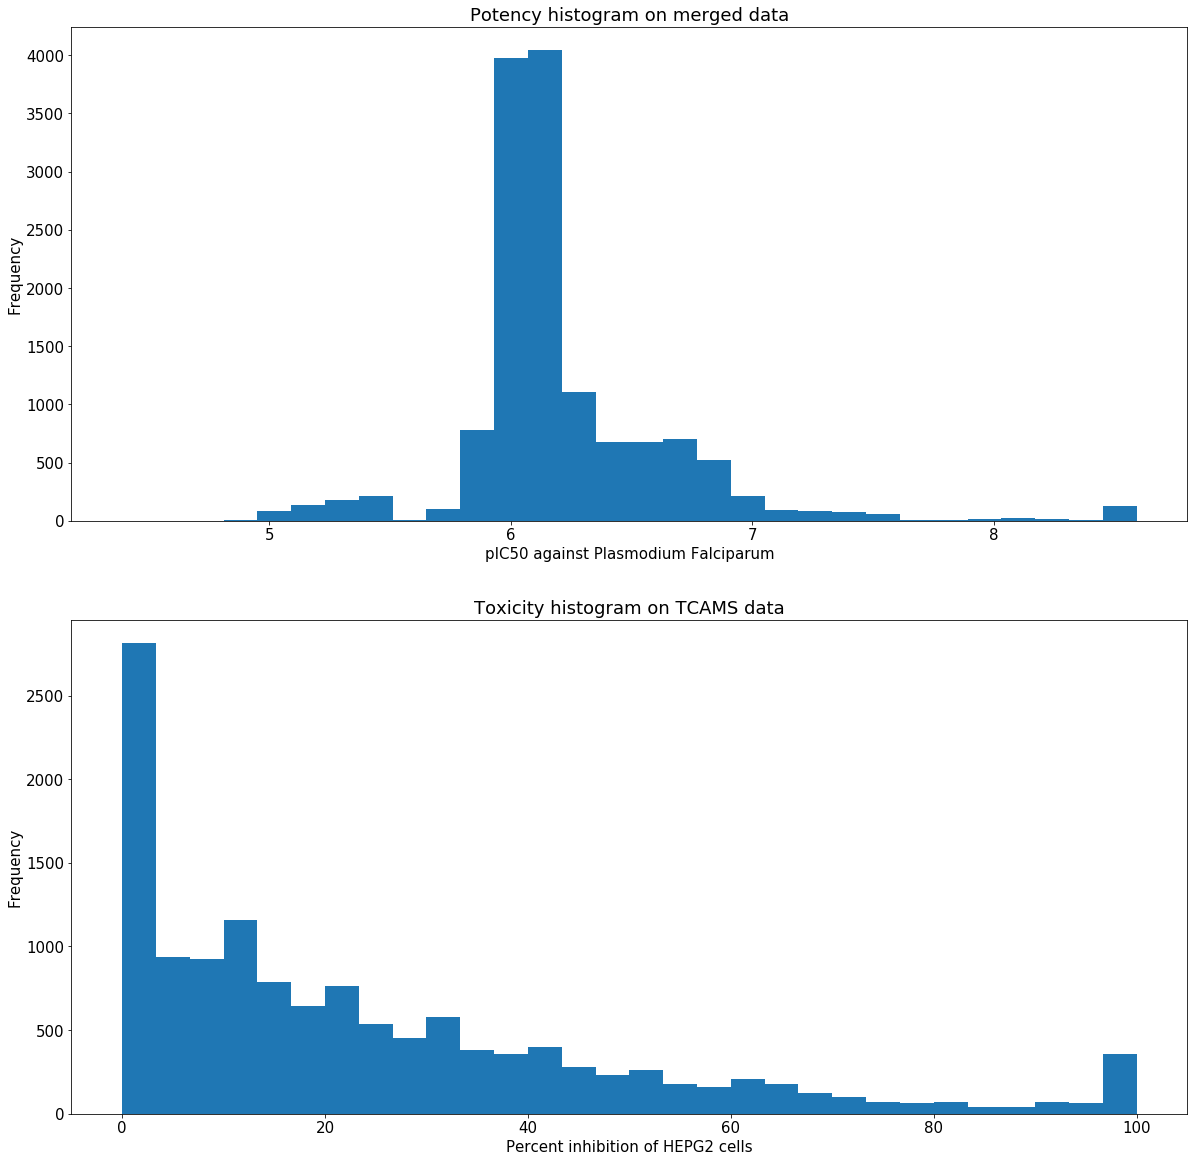

In [148]:
# Figure 1 in the paper
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
full_df.POTENCY.plot.hist(bins=30)
_ = plt.title('Potency histogram on merged data')
plt.xlabel('pIC50 against Plasmodium Falciparum')
plt.subplot(212)
df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].plot.hist(bins=30)
plt.xlabel('Percent inhibition of HEPG2 cells')
_ = plt.title('Toxicity histogram on TCAMS data')
savefig('figures/fig1_hists.png')

# 3. Modelling potency

We will only report the main modelling results we obtained. In particular - we will do 'naive' in/out-of-sample testing, having done nothing but remove duplicates in order to force our two sets to be distinct.  

Let's just look at the performance of Naive Random forest performance on the whole dataset, together with a plot...

In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV

model_dict = {'ridge' : {'m': Ridge, 'kw': {'fit_intercept': True, 'alpha': 0.1}},
              'rcv':  {'m': RidgeCV, 'kw': {'cv': 5}},
              'rf': {'m': RandomForestRegressor, 'kw': {'n_estimators': 100, 'n_jobs': 4, 'max_depth': 10}}}

method = 'rf'
mdl = model_dict[method]['m'](**model_dict[method]['kw'])
target = full_df.POTENCY.values
gd = ~np.isnan(target)
preds = np.asarray([x for x in full_df.fps[gd]])

mdl.fit(preds, target)
fc = mdl.predict(preds)

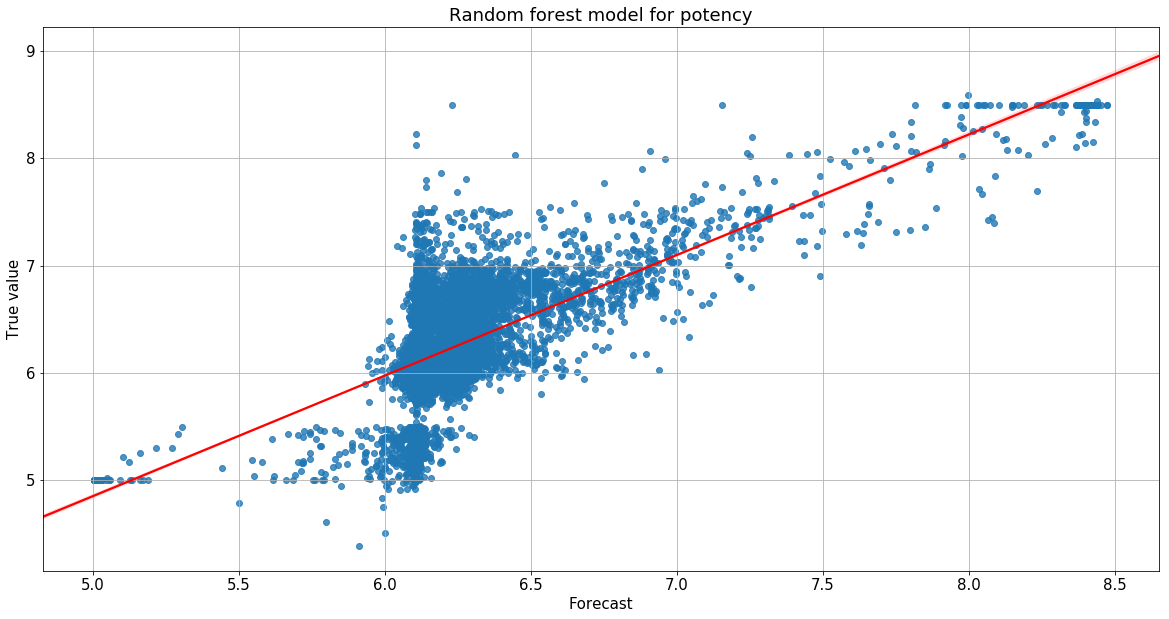

In [139]:
figsize(20, 10)
import seaborn as sns
sns.regplot(x=fc,y=target,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('Random forest model for potency')
plt.xlabel('Forecast')
plt.ylabel('True value')
plt.grid(True)

We first look at the fit to the training data:

In [142]:
stats.regress(target, [fc,])

Coeffs:       1.0003 
R-squared:    0.5249
RMSE:    0.3073
R-squared mean model:    0.0000
RMSE mean model:    0.4458


Next, we perform bootstrap to evaluate the performance of the models on out-of-sample data modelling potency, using binary and hashed fingerprints.

The run below, which shows bootstrapped OOS performance of ridge and random forest algorithms, on binary and hashed fingerprints gives us the following results.

- Random forests substantially outperform ridge - and do slightly better on binary fingerprints. 

As a baseline, we consider a *mean model*, which consists of simply using the mean potency value for the trianing molecules as a prediction for the hold-out instances.

In [143]:
stats.run_suite(full_df, 'POTENCY')

('Analyzing', 'POTENCY')
Beta:             0.999 [   0.998    1.000] ridge
R2 (signed):      0.299 [   0.265    0.324] at 5pct conf
RMSE:      0.375 [   0.369    0.380] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:      0.448 [   0.435    0.462] at 5pct conf
Beta:             1.000 [   0.999    1.001] rf
R2 (signed):      0.399 [   0.381    0.418] at 5pct conf
RMSE:      0.346 [   0.336    0.354] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:      0.446 [   0.435    0.456] at 5pct conf

Hashed...
Beta:             0.999 [   0.998    1.000] ridge
R2 (signed):      0.257 [   0.219    0.278] at 5pct conf
RMSE:      0.384 [   0.378    0.391] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:      0.445 [   0.434    0.455] at 5pct conf
Beta:             1.000 [   0.999    1.001] rf
R2 (signed):      0.397 [   0.363    0.422] at 5pct conf
RMSE:

# 4. Modelling Toxicity

We now analyze toxicity models using the TCAMS data.  Again we find that random forests substantially outperform ridge - and this time using hashed fingerprints is slightly better.  The main result though is that adding logP as a predictor improves the model (extra 2% of R2).  This isn't the case for adding QED as a predictor (not shown).

In [71]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
#fps = [get_fp(x, countfp=True) for x in df_tcams_nd.index]
#df_tcams_nd['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=df_tcams_nd.index)
#hfps = [get_fp(x, countfp=True) for x in df_tcams_nd.index]
#df_tcams_nd['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df_tcams_nd.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#df_tcams_nd['crippen'] = crippen
#df_tcams_nd['qed'] = qed
#df_tcams_nd.to_pickle('TCAMS_processed_tox.pkl')
df_tcams_nd = pd.read_pickle('TCAMS_processed_tox.pkl')

RDKit ERROR: [12:41:07] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [12:41:34] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [12:42:13] SMILES Parse Error: syntax error for input: 'None'
RDKit ERROR: [12:43:48] SMILES Parse Error: syntax error for input: 'None'


In [169]:
# To reload python modules without requiring to restart the kernel
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import stats
stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2')

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.922 [   0.904    0.936] ridge
R2 (signed):      0.235 [   0.222    0.245] at 5pct conf
RMSE:     21.871 [  21.615   22.110] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:     24.859 [  24.645   25.094] at 5pct conf
Beta:             1.027 [   0.998    1.046] rf
R2 (signed):      0.283 [   0.266    0.297] at 5pct conf
RMSE:     21.035 [  20.673   21.279] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:     24.821 [  24.559   24.990] at 5pct conf

Hashed...
Beta:             0.909 [   0.885    0.930] ridge
R2 (signed):      0.253 [   0.234    0.268] at 5pct conf
RMSE:     21.546 [  21.239   21.809] at 5pct conf
R2 mean model (signed):      0.000 [   0.000    0.000] at 5pct conf
RMSE mean model:     24.728 [  24.381   25.014] at 5pct conf
Beta:             1.032 [   1.016    1.058] rf
R2 (signed):      0.316 [   0.299    0.333] at 5pct co

... and if we add an extra predictor of logP

In [79]:
stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2', add_pred=df_tcams_nd.crippen.values[:,None])

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.989 [   0.958    1.023] ridge
R2 (signed):      0.157 [   0.144    0.173] at 5pct conf
Beta:             1.013 [   0.992    1.037] rf
R2 (signed):      0.319 [   0.304    0.337] at 5pct conf

Hashed...
Beta:             0.986 [   0.963    1.016] ridge
R2 (signed):      0.187 [   0.174    0.201] at 5pct conf
Beta:             1.030 [   1.010    1.053] rf
R2 (signed):      0.338 [   0.319    0.358] at 5pct conf




# 5. Tanimoto distance


Now, we going to compute the sample standard deviations as a function of Tanimoto distance.  We'll start with the easiest one - 0...

So we're going to have a bunch of samples of different sizes.  The global estimate of the standard deviation is the weighted mean of the different sample estimates, weighted by the sample size

In [157]:
fpa = np.asarray([x for x in full_df.fps.values])

fpa = np.asarray([x for x in full_df.fps.values])

estimates = []
weights = []

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa)[0]
    dists[i]+=1
    gpot = full_df.POTENCY.values[dists == 0]
    if len(gpot) == 0:
        continue
    gpot = np.concatenate((v, gpot))
    estimates.append(np.std(gpot, ddof=1))
    weights.append(gpot.shape[0]-1)
    pass

print('Standard deviation of potency values in our dataset')
print(np.std(full_df.POTENCY.values, ddof=1))
print('Standard deviation of compounds with identical fingerprints')
print(np.average(estimates, weights=weights))
print('Fraction of variance thus explained by fingerprints...')
1-np.average(estimates, weights=weights)**2/np.std(full_df.POTENCY.values, ddof=1)**2

Standard deviation of potency values in our dataset
0.4457859827217044
Standard deviation of compounds with identical fingerprints
0.14401254569005675
Fraction of variance thus explained by fingerprints...


0.8956366916305518

This is a really important result.  The standard deviation of the potency values for malaria of two compounds with identical 1024-bit fingerprints is 0.185 (and we have 665 effective datapoints for this estimate, accounting for double-counting).  This means that the 1024-bit fingerprint captures 84% of the variance in potency (which is decent!)

What we actually want here is a plot showing the sensitivity of sigma to Tanimoto distance.  So let's construct that, and for toxicity, and plot them (and thus create figure 2 of the paper).


First though - let's just show some examples for the reader of a couple of compounds that are different (and have different potency/toxicity values, but the same fingerprints, and also a couple of compounds that have opposite fingerprints...

In [158]:
from sklearn.metrics.pairwise import pairwise_distances
sum_fp = pd.Series([sum(x) for x in full_df.fps], index=full_df.index)
full_df['good_fp'] = sum_fp
full_dfg = full_df.loc[full_df['good_fp'] >0]
v  = (pairwise_distances(np.asarray([x for x in full_dfg.fps.values]), metric='jaccard') == 0).nonzero()
diffs = np.asarray([full_dfg.iloc[v[0][x]].POTENCY - full_dfg.iloc[v[1][x]].POTENCY for x in range(len(v[0]))])
b = np.argmax(np.abs(diffs))
a = [v[0][b], v[1][b]]
labels = ['Potency %.2f' % (full_dfg.iloc[x].POTENCY) for x in a]

In [159]:
opposites  = (pairwise_distances(np.asarray([x for x in full_dfg.fps.values]), metric='jaccard') == 1).nonzero()
ao = [opposites[0][0], opposites[1][0]]
olabels = ['Potency %.2f' % (full_dfg.iloc[x].POTENCY) for x in ao]

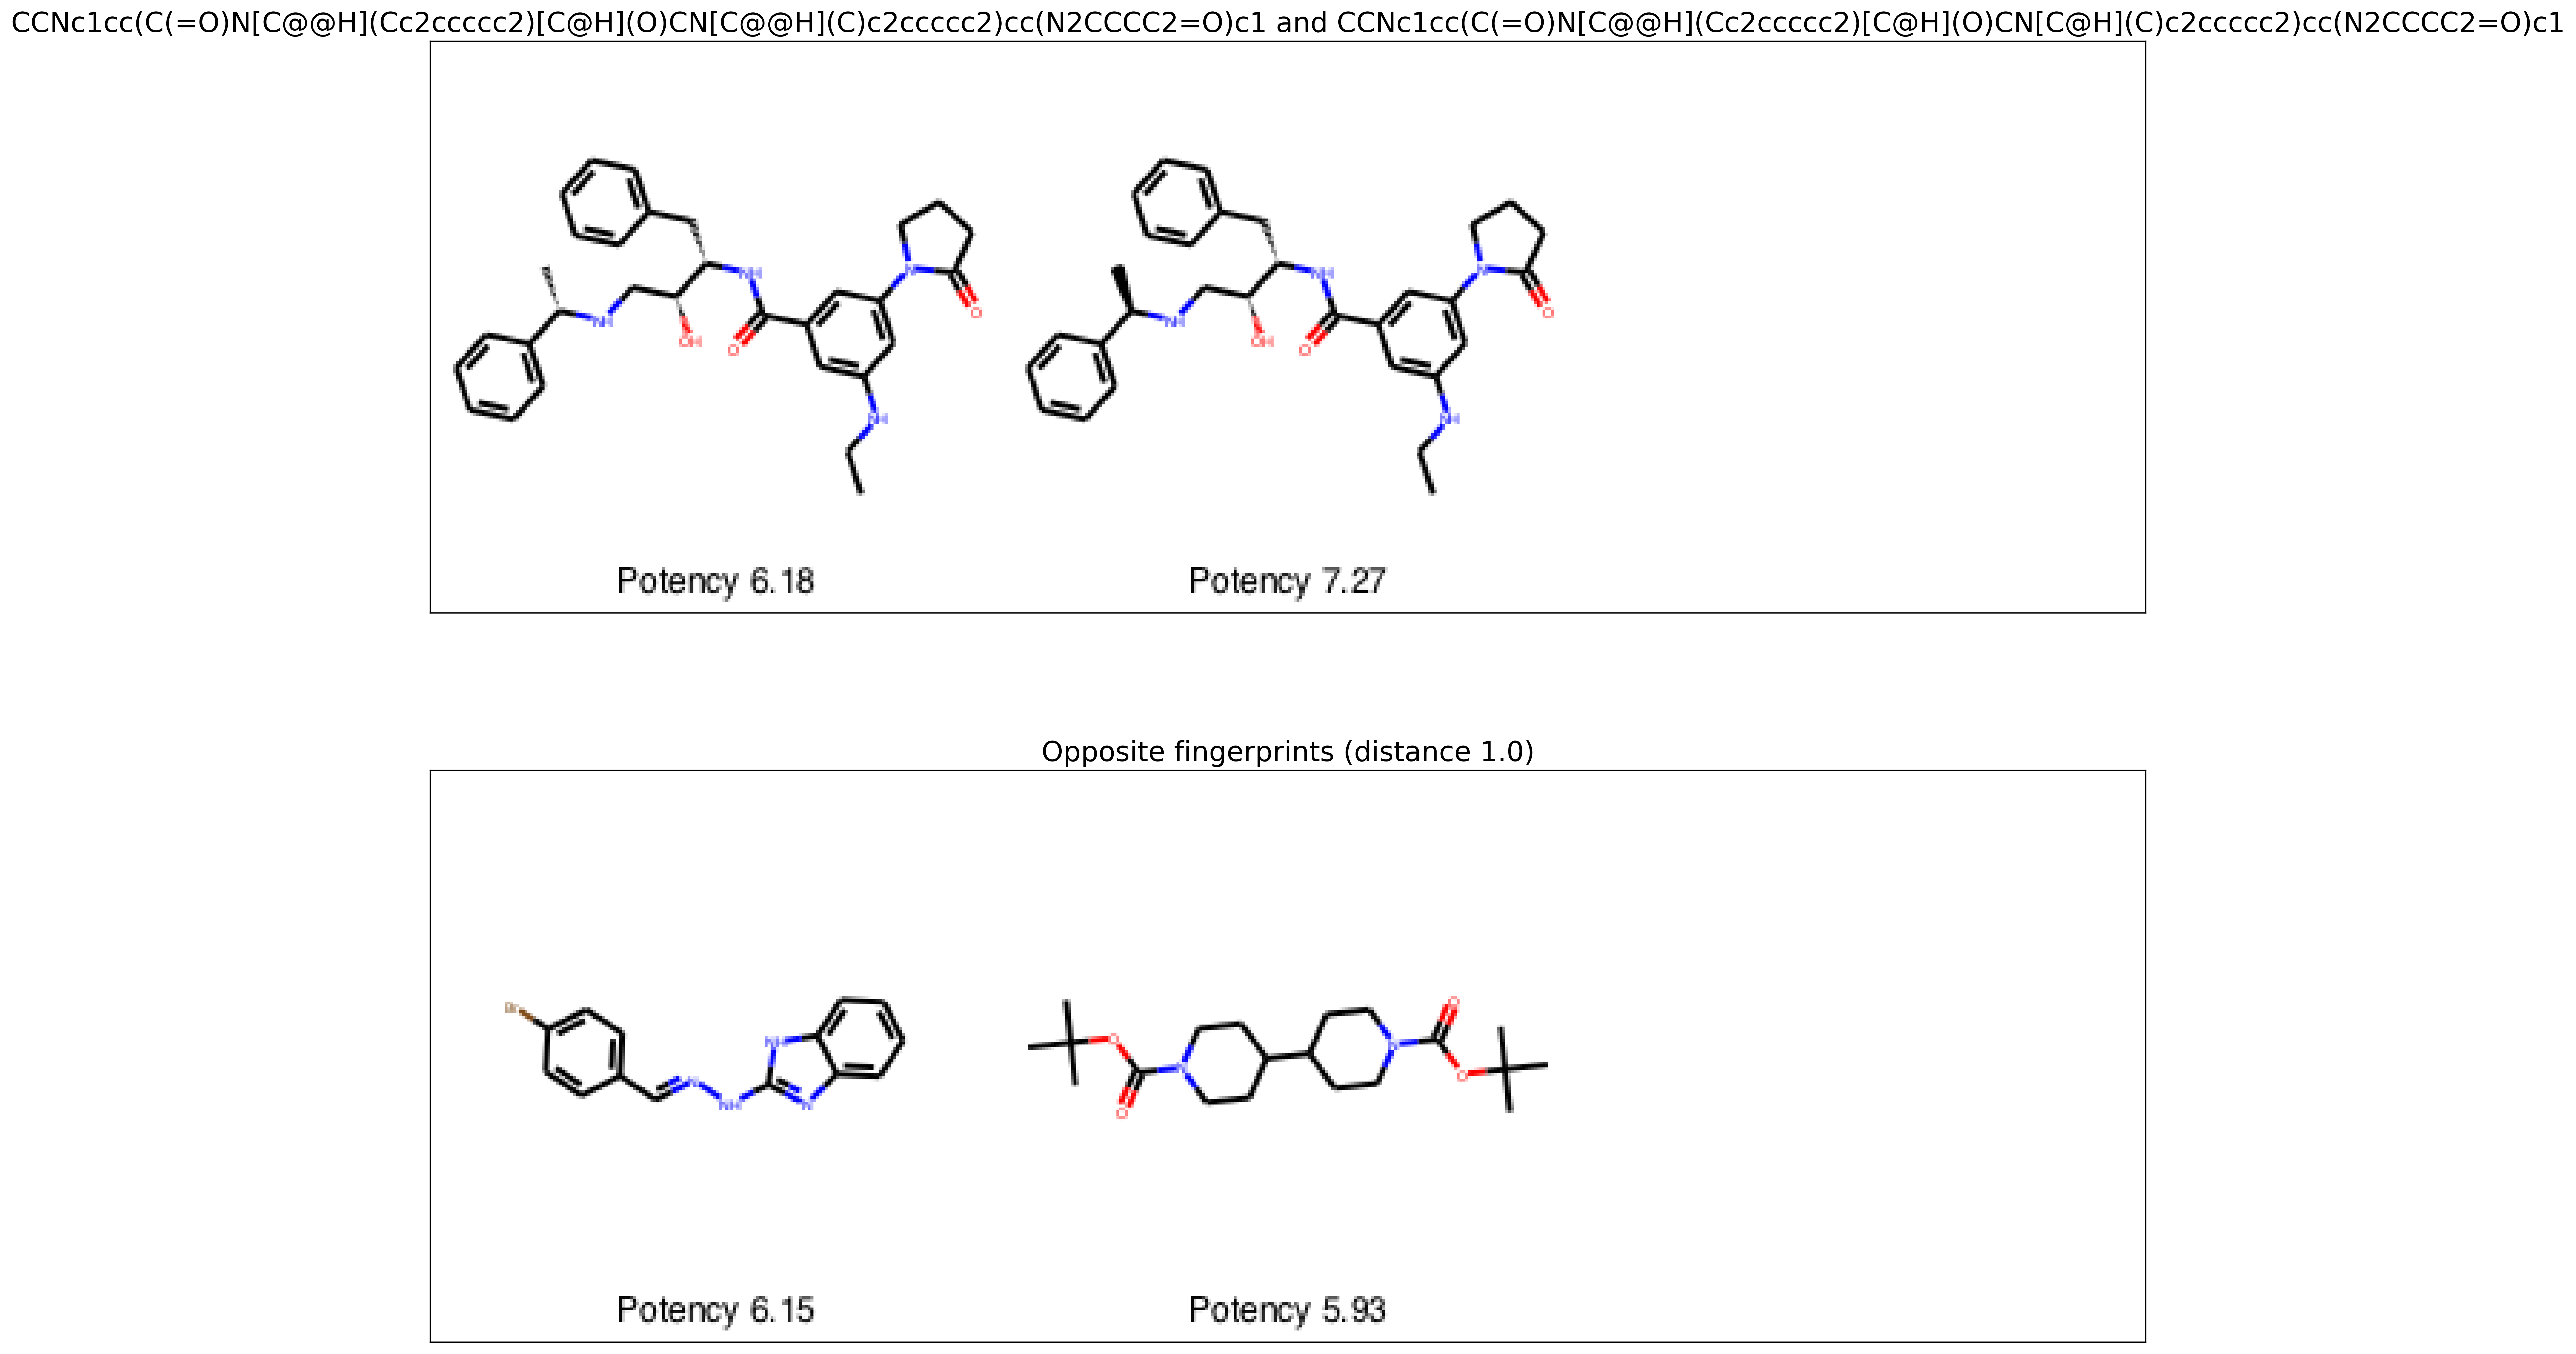

In [160]:
my_smiles = [full_dfg.index[x] for x in [v[0][b], v[1][b]]]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 16), dpi=400)
plt.subplot(211)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(full_dfg.index[x]) for x in a], 
                          legends=labels)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('%s and %s' % tuple(my_smiles))
plt.subplot(212)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(full_dfg.index[x]) for x in ao], 
                          legends=olabels)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Opposite fingerprints (distance 1.0)')
savefig('figures/fig2_same_and_opposite.png')

### Figure 2.

/Users/isidro/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/isidro/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/isidro/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
/Users/isidro/anaconda/envs/my-rdkit-env/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less_equal


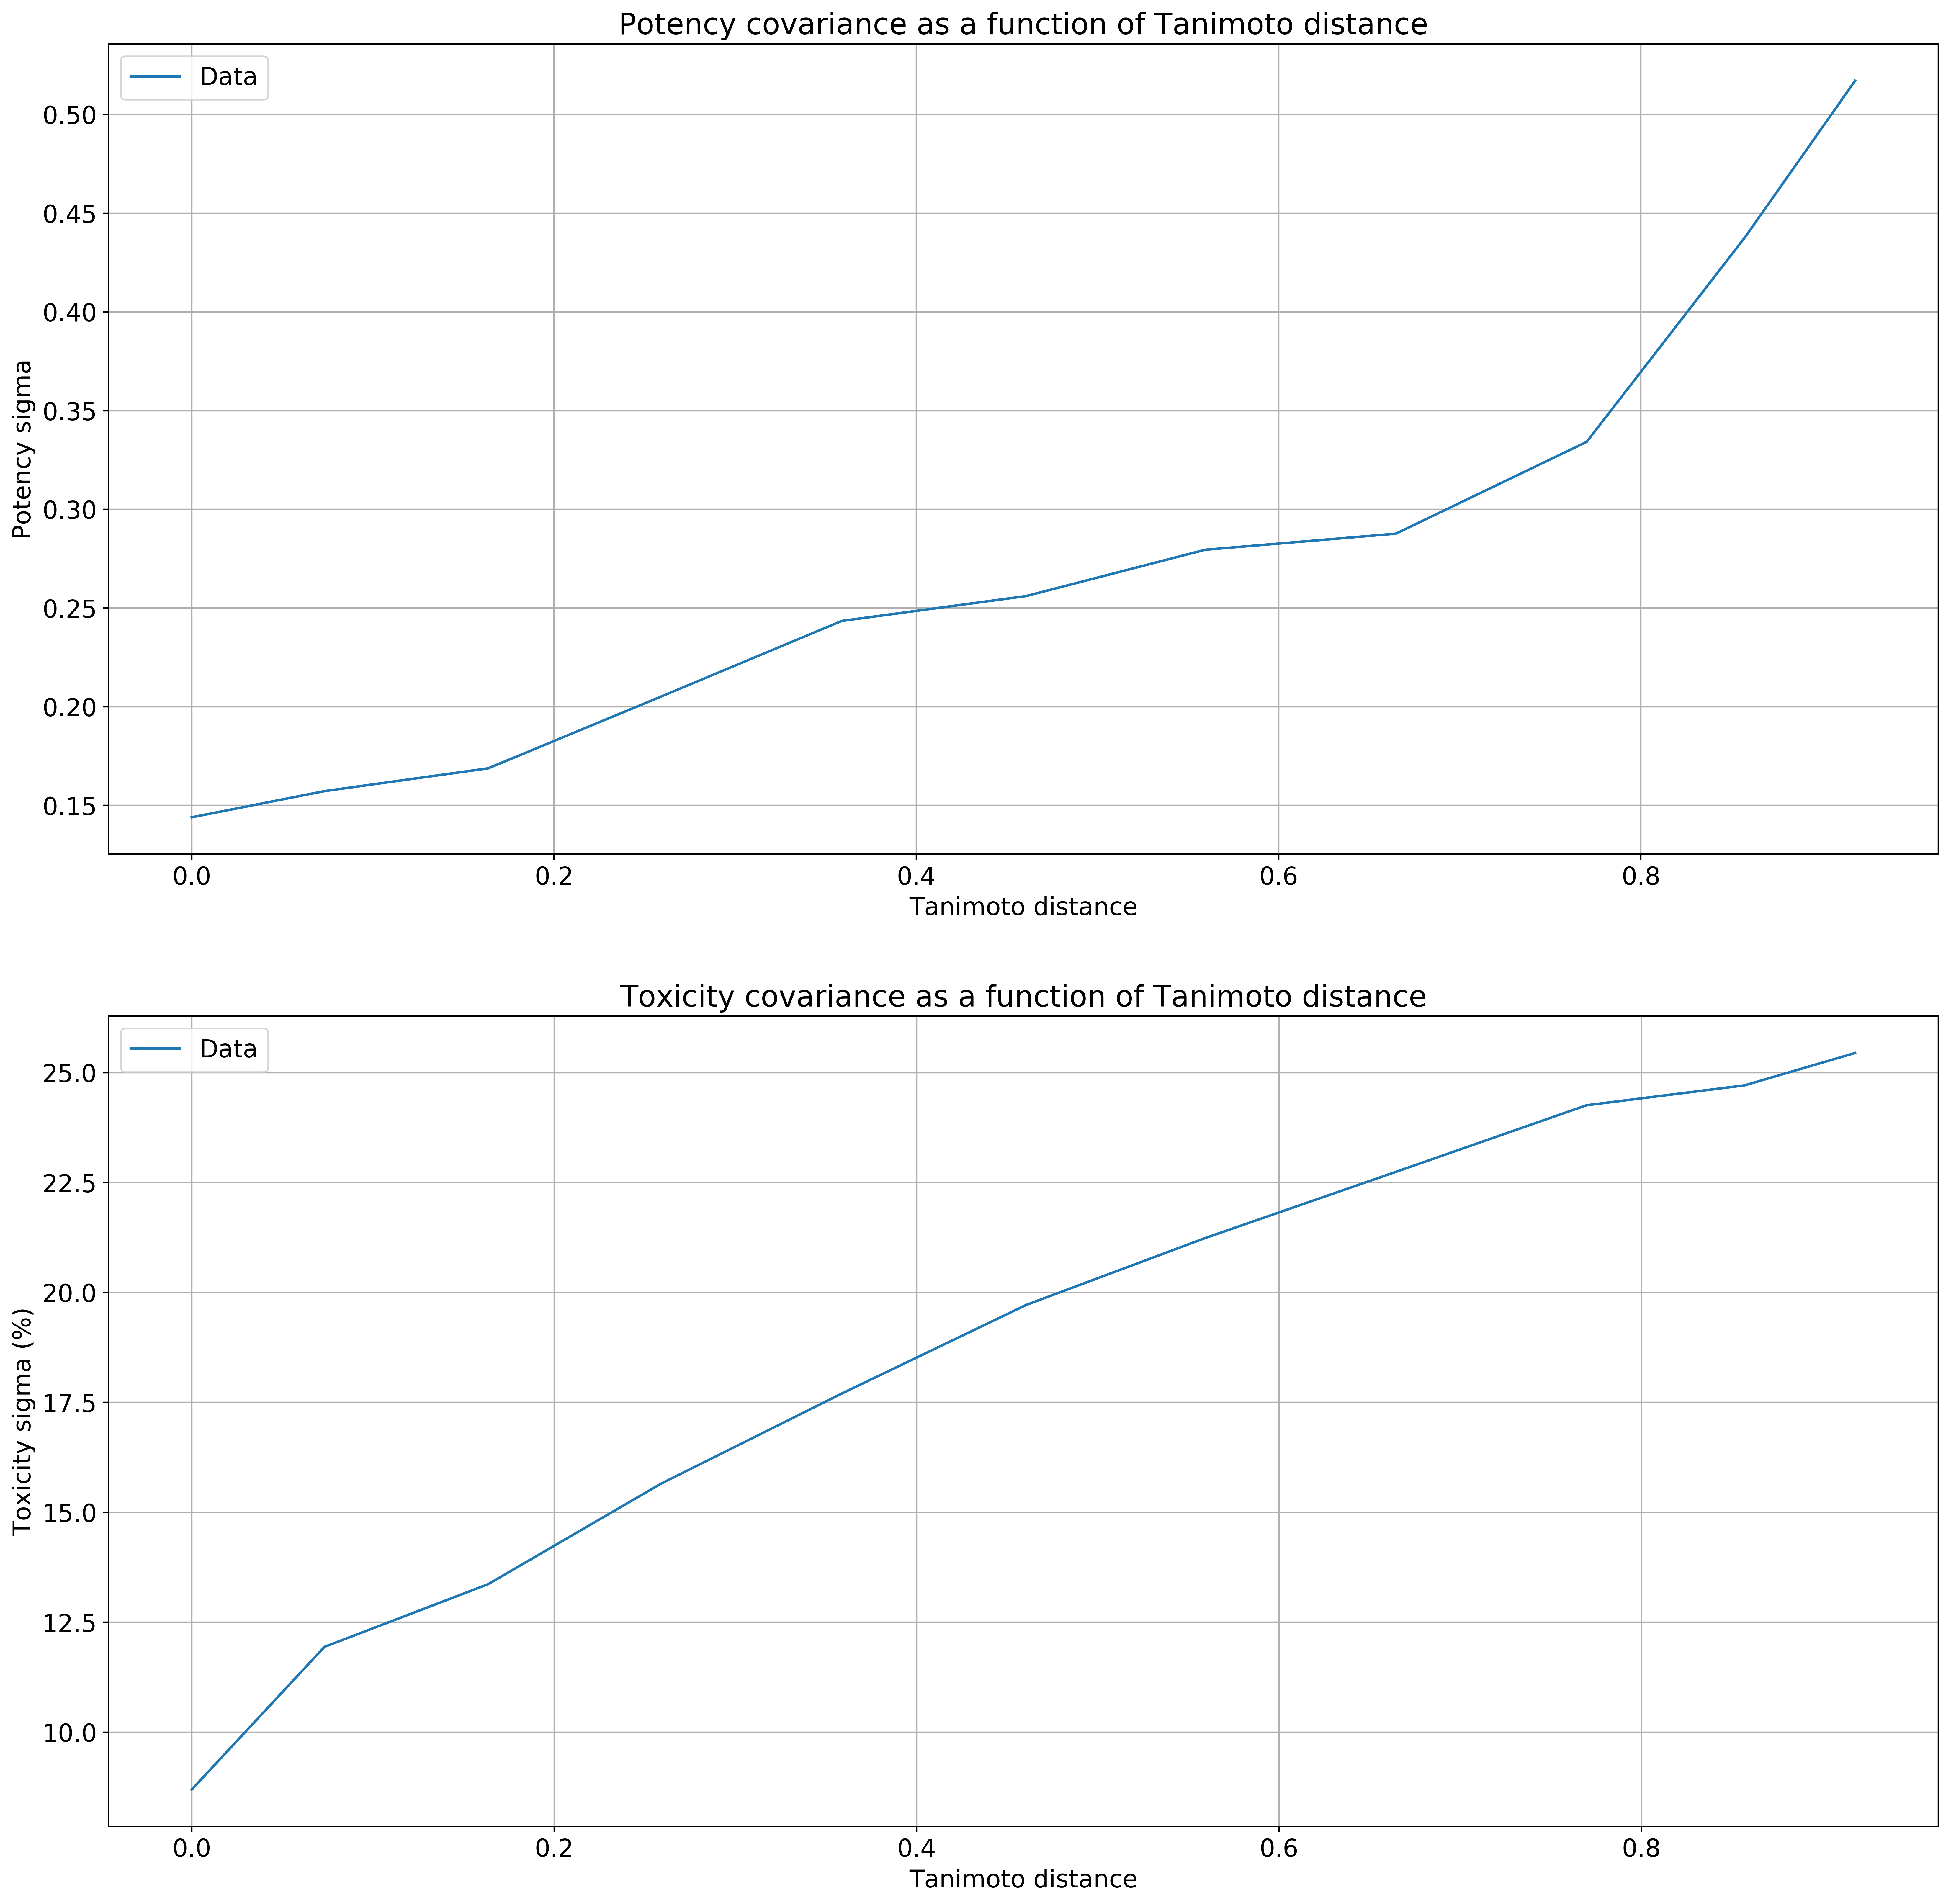

In [161]:
estimates_hdr = {}
weight_hdr = {}
ctr_hdr = {}

bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(bins)-1):
    estimates_hdr[i] = []
    weight_hdr[i] = []
    ctr_hdr[i] = []
    pass

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = full_df.POTENCY.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_hdr[j].append(np.std(gpot, ddof=1))
        weight_hdr[j].append(gpot.shape[0]-1)
        ctr_hdr[j].append(np.mean(dists[gd]))
        pass
    pass     

ctrs = np.asarray([np.average(ctr_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])
sigmas = np.asarray([np.average(estimates_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])

#stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2', add_pred=df_tcams_nd.crippen.values[:,None])

estimates_tox_hdr = {}
weight_tox_hdr = {}
ctr_tox_hdr = {}

bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tox = df_tcams_nd.dropna(subset=['PCT_INHIB_HEPG2'])
fpat = np.asarray([x for x in df_tox.fps.values])


for i in range(len(bins)-1):
    estimates_tox_hdr[i] = []
    weight_tox_hdr[i] = []
    ctr_tox_hdr[i] = []
    pass

for i in range(df_tox.shape[0]):
    v = [df_tox.PCT_INHIB_HEPG2.values[i]]
    dists = cdist(np.asarray([df_tox.fps.values[i],]), fpat, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = df_tox.PCT_INHIB_HEPG2.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_tox_hdr[j].append(np.std(gpot, ddof=1))
        weight_tox_hdr[j].append(gpot.shape[0]-1)
        ctr_tox_hdr[j].append(np.mean(dists[gd]))
        pass
    pass        


ctrst = np.asarray([np.average(ctr_tox_hdr[i], weights=weight_tox_hdr[i]) for i in range(len(bins)-1)])
sigmast = np.asarray([np.average(estimates_tox_hdr[i], weights=weight_tox_hdr[i]) for i in range(len(bins)-1)])

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
plt.plot(ctrs, sigmas, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Potency sigma')
legend(loc='best')
_ = title('Potency covariance as a function of Tanimoto distance')
plt.subplot(212)
plt.plot(ctrst, sigmast, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Toxicity sigma (%)')
legend(loc='best')
_ = title('Toxicity covariance as a function of Tanimoto distance')
savefig('figures/fig2_covariance.jpg')

So now we understand how covariance works as a function of Tanimoto distance - let's see how our models perform when they are restricted to fitting on points above some minimum Tanimoto distance from the target point...

In [166]:
fc_rf_hdr = {}
fc_lr_hdr = {}
ctr_hdr = {}  # this tells you the mean distance...

def rank(x):
    return np.argsort(np.argsort(x))/(len(x) + 0.) - 0.5

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]


def run_big_fit():
    md = stats.get_model_dict()

    for i in range(len(bins)):
        fc_rf_hdr[i] = []
        fc_lr_hdr[i] = []
        ctr_hdr[i] = []
        pass
    

    for i in range(full_df.shape[0]):
    
        if i < 10:
            print ('Doing', i)
            print(datetime.datetime.now().time())
        elif i < 100:
            if (i % 10) == 0:
                print ('Doing', i)
                print(datetime.datetime.now().time())
        else:
            if (i % 100) == 0:
                print ('Doing', i)
                print(datetime.datetime.now().time()) 
            
        my_fp = np.asarray([full_df.fps.values[i],])
        dists = cdist(my_fp, fpa, metric='jaccard')[0]
        dists[i]-=2 # to exclude from anything (we're going to use >)
    
        for j in range(len(bins)):
            bstart = bins[j]

            gd = (dists >= bstart) 
    
            prd_i_rf = md['rf']['m'](**md['rf']['kw']).fit(fpa[gd], 
                    full_df.POTENCY.values[gd]).predict(my_fp)
        
            prd_i_rdg = md['ridge']['m'](**md['ridge']['kw']).fit(fpa[gd], 
                    full_df.POTENCY.values[gd]).predict(my_fp)
    
            fc_rf_hdr[j].append(prd_i_rf[0])
            fc_lr_hdr[j].append(prd_i_rdg[0])

            ctr_hdr[j].append(np.mean(dists[gd]))
            pass
        pass   
    return

joblib.dump(fc_rf_hdr, 'modelling/rf_fc_results')
joblib.dump(fc_lr_hdr, 'modelling/rdg_fc_results')
joblib.dump(ctr_hdr, 'modelling/ctr_results')
fc_rf_hdr = joblib.load('modelling/rf_fc_results')
fc_lr_hdr = joblib.load('modelling/rdg_fc_results')
ctr_hdr = joblib.load('modelling/ctr_results')

In [175]:
import stats
result_hdr = {'rf' : [], 'rdg' : [], 'rfrk' : [], 'rdgrk' : [], 
             'rfb' : [], 'rdgb' : [], 'rfrkb' : [], 'rdgrkb' : [] 
             }#

print(fc_rf_hdr[i])
for i in range(len(bins)):
    rf_beta, rf_r2, rmse, r2_mean, rmse_mean = stats.regress(full_df.POTENCY.values, [fc_rf_hdr[i],], do_print=False, one=True)
    rdg_beta, rdg_r2, rmse, r2_mean, rmse_mean = stats.regress(full_df.POTENCY.values, [fc_lr_hdr[i],], do_print=False, one=True)
    rfr_beta, rfr_r2, rmse, r2_mean, rmse_mean = stats.regress(rank(full_df.POTENCY.values), [rank(fc_rf_hdr[i]),], 
                                     do_print=False)
    rdgr_beta, rdgr_r2, rmse, r2_mean, rmse_mean = stats.regress(rank(full_df.POTENCY.values), [rank(fc_lr_hdr[i]),], 
                                       do_print=False)   
    
    result_hdr['rf'].append(rf_r2)
    result_hdr['rfb'].append(rf_beta[0])
    result_hdr['rdg'].append(rdg_r2)
    result_hdr['rdgb'].append(rdg_beta[0])
    result_hdr['rfrk'].append(rfr_r2)
    result_hdr['rfrkb'].append(rfr_beta[0])
    result_hdr['rdgrk'].append(rdgr_r2)
    result_hdr['rdgrkb'].append(rdgr_beta[0])
       
result_hdr = joblib.load('results/summary_results')

KeyError: 0

### Figure 3.

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

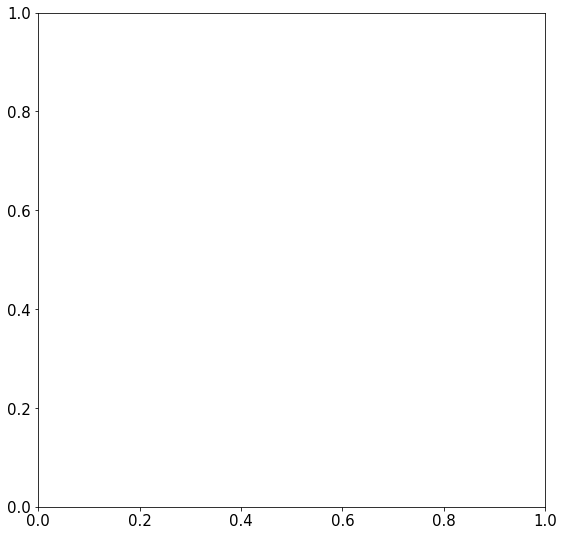

In [173]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.9]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Potency model strength')
plt.subplot(222)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.4))
plt.grid(True); plt.legend(loc='best')
plt.title('Potency R2')

result_hdr = joblib.load('results_tox/summary_results')
plt.subplot(223)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Toxicity model strength')
plt.subplot(224)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.4))
plt.grid(True); plt.legend(loc='best')
_ = plt.title('Toxicity R2')
savefig('figures/fig3_str_r2.png')

# 6. Dealing with the bias in the data set

Unfortunately we need to deal with the bias in the data - hence we need to work out how to correct for it.  Here we run the analysis described in the paper to perform the bias correction.

In [87]:
tc_dists = cdist(fpa, fpa, metric='jaccard') + np.diag(np.ones(len(fpa)) * np.nan)
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')
df0 = pd.read_pickle(std_files[0])
idcs = np.random.choice(np.arange(df0.shape[0]), 10000)
fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
r_dists = cdist(fpr, fpr, metric='jaccard') + np.diag(np.ones(len(fpr)) * np.nan)
tcr_dists = cdist(fpr, fpa, metric='jaccard')
mal_hist= np.histogram(tc_dists[~np.isnan(tc_dists)], density=True, bins=7)
mr_hist = np.histogram(tcr_dists[~np.isnan(tcr_dists)], density=True, bins=7)

# magic number - but justified by looking at the bottom plot below.
num_inactive_per_active = 100

### Figure 4.

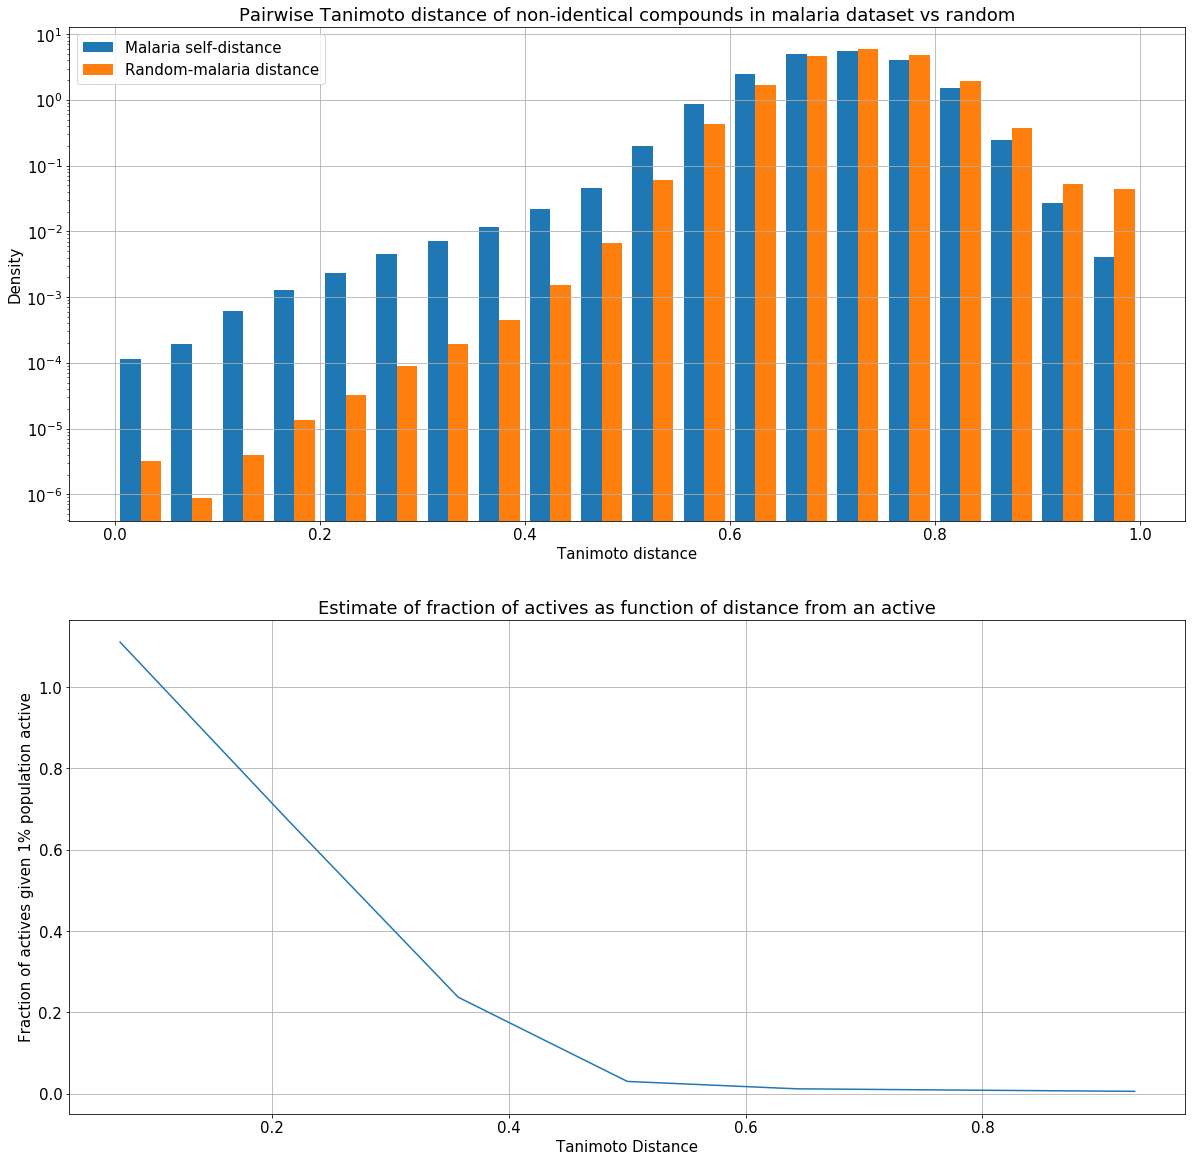

In [88]:
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.hist((tc_dists[~np.isnan(tc_dists)],tcr_dists[~np.isnan(tcr_dists)]), 
         bins=20, density=True, label=('Malaria self-distance', 'Random-malaria distance'))
#plt.hist(r_dists[~np.isnan(r_dists)], bins=20, label='Random distances')
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')
plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')
plt.subplot(212)
plt.plot(x_axis, mal_hist[0]/(num_inactive_per_active*mr_hist[0]))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given 1% population active')
_ = plt.title('Estimate of fraction of actives as function of distance from an active')
savefig('figures/fig4_bias_correction.png')

# 7. Using our models

Now we can actually create a proper extrapolative model to use in predicting on general compounds...

In [89]:
from functools import partial
frac_active = partial(np.interp, xp=x_axis, fp=(mal_hist[0]/(num_inactive_per_active*mr_hist[0])).clip(0., 1.))

# magic number - but with some emprical support in the paper...
inactive_level = 4.0
active_level = np.mean(full_df.POTENCY.values)
rf_beta = partial(np.interp, xp=bins, fp=result_hdr['rfb'])

# first fit full models....
reload(stats)
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_models = stats.fit_models(df_tcams_nd, full_df)
from malaria import mp_utils

full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

In [90]:
# Adding minimum distance from training set data to the Molport data...
from malaria import mp_utils

#min_dist = np.ones(mp1.shape[0])
#mp1 = pd.read_pickle(std_files[0])
#mp1_fps = np.asarray([x for x in mp1.fps.values])
blk = []
smile_blk = []

def make_blocks():
    for i in range(1, full_df.shape[0], 1000):
        e = min(i+1000, full_df.shape)
        blk.append(np.asarray([x for x in full_df.fps.values[i:e]]))
        smile_blk.append([x for x in full_df.index[i:e]])
        pass

#make_blocks()

def add_min_dist(fn):
    mp_df = pd.read_pickle(fn)
    
    mins = np.ones(mp_df.shape[0], dtype=float)
    amins = np.ones(mp_df.shape[0], dtype=float)
    min_smiles = mp_df.SMILESIS.values.copy()
    mp1_fps = np.asarray([x for x in mp_df.fps.values])
    
    for (i, bl) in enumerate(blk):
        bl_min = np.min(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        amin = np.argmin(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        
        min_smiles[bl_min < mins] = np.asarray(smile_blk[i])[amin[bl_min < mins]]
        mins = np.minimum(mins, bl_min)
    
    md = pd.Series(mins, index=mp_df.index)
    sm = pd.Series(min_smiles, index=mp_df.index)
    mp_df['min_dist'] = md
    mp_df['min_smile'] = sm
    mp_df.to_pickle(fn)
    
#for fn in std_files:
    #add_min_dist(fn)    

Now choose the top compounds from Molport accoriding to various criteria...

### Figure 5.

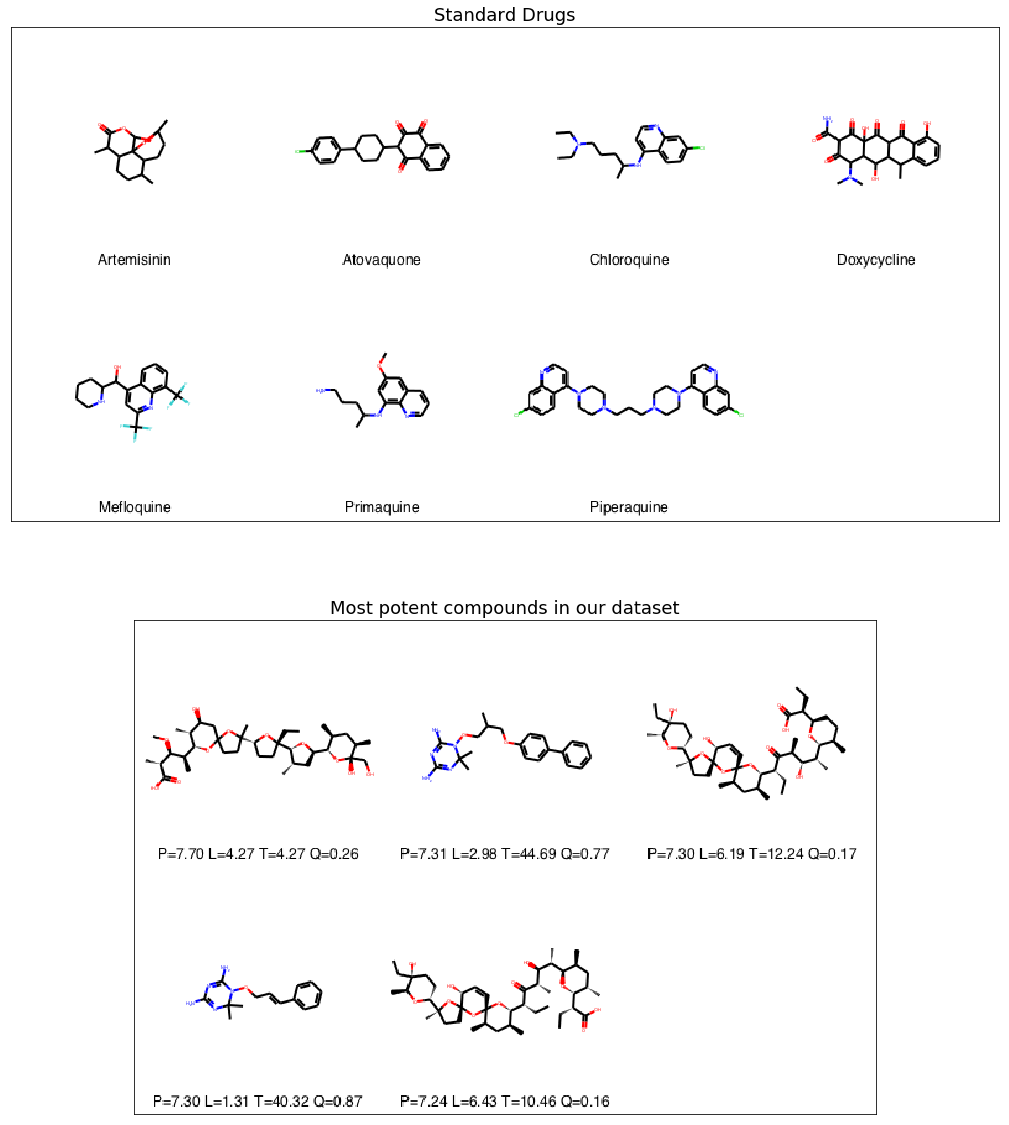

In [91]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']

# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels, molsPerRow=4)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Standard Drugs')
plt.subplot(212)
fig = mp_utils.summarize('POT', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Most potent compounds in our dataset')
savefig('figures/fig5_drugs_n_pot.png')

### Figure 6.

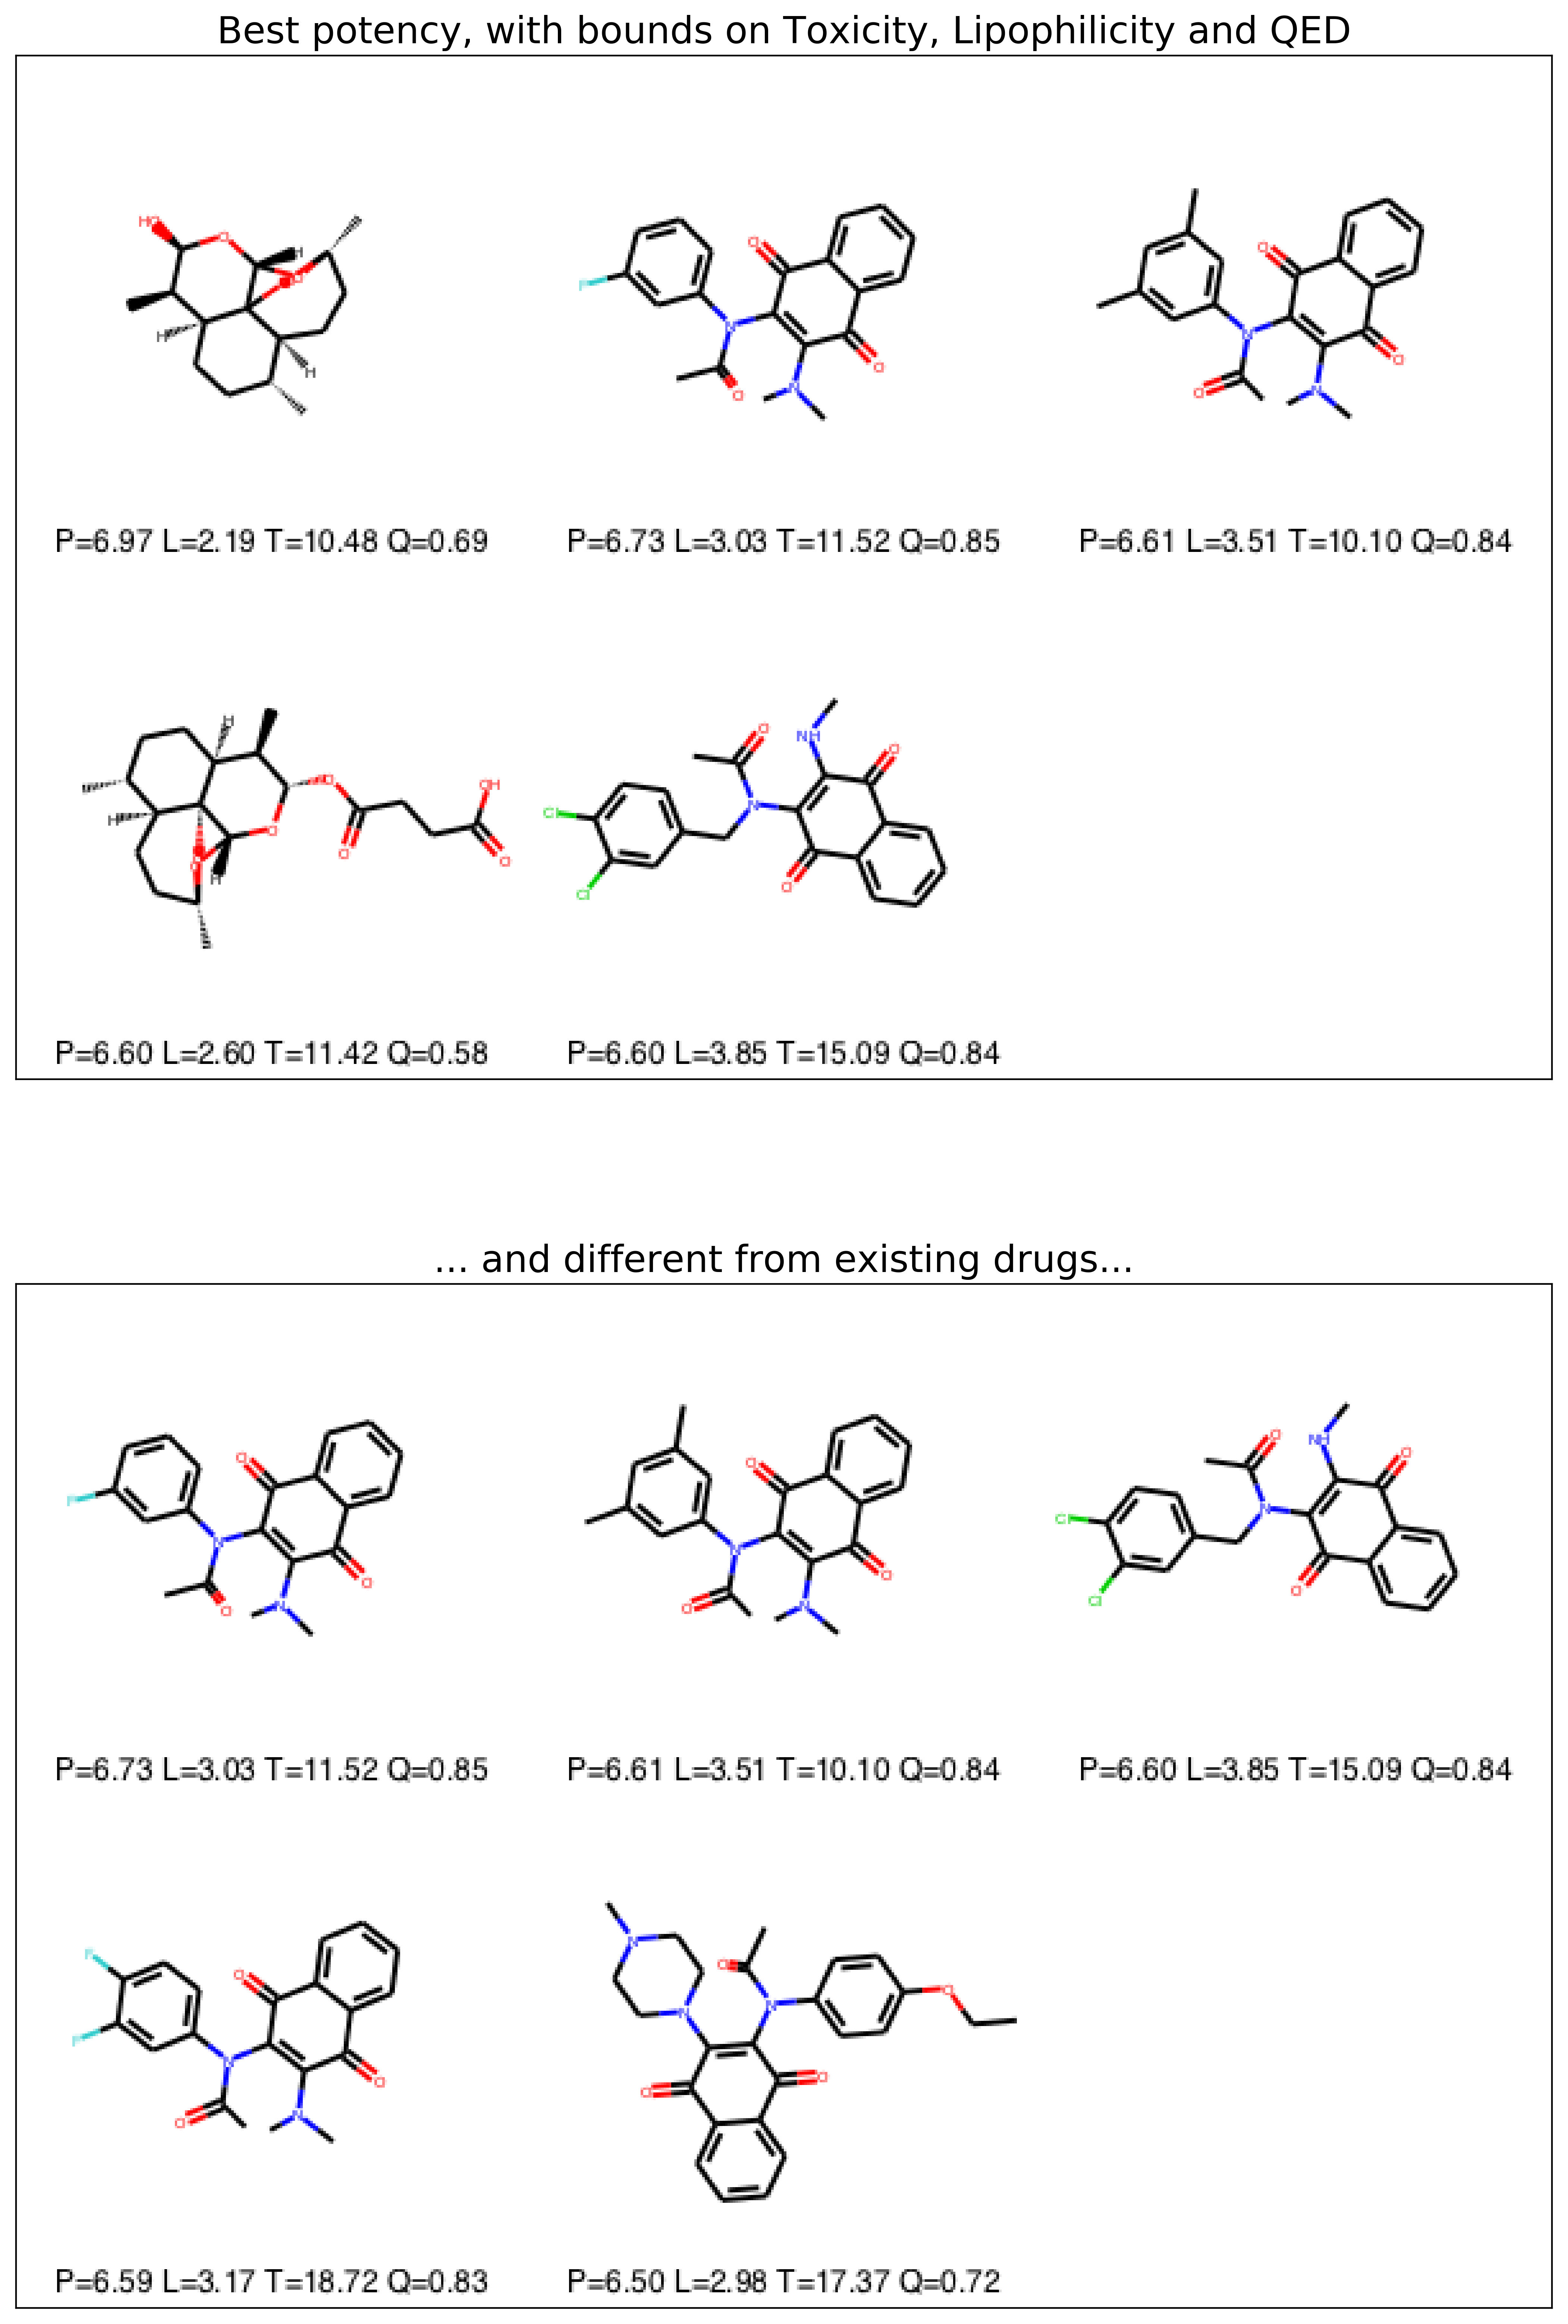

In [92]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_Q', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Best potency, with bounds on Toxicity, Lipophilicity and QED')
plt.subplot(212)
fig = mp_utils.summarize('BEST_D', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('... and different from existing drugs...')
savefig('figures/fig6.png')

### Figure 7.

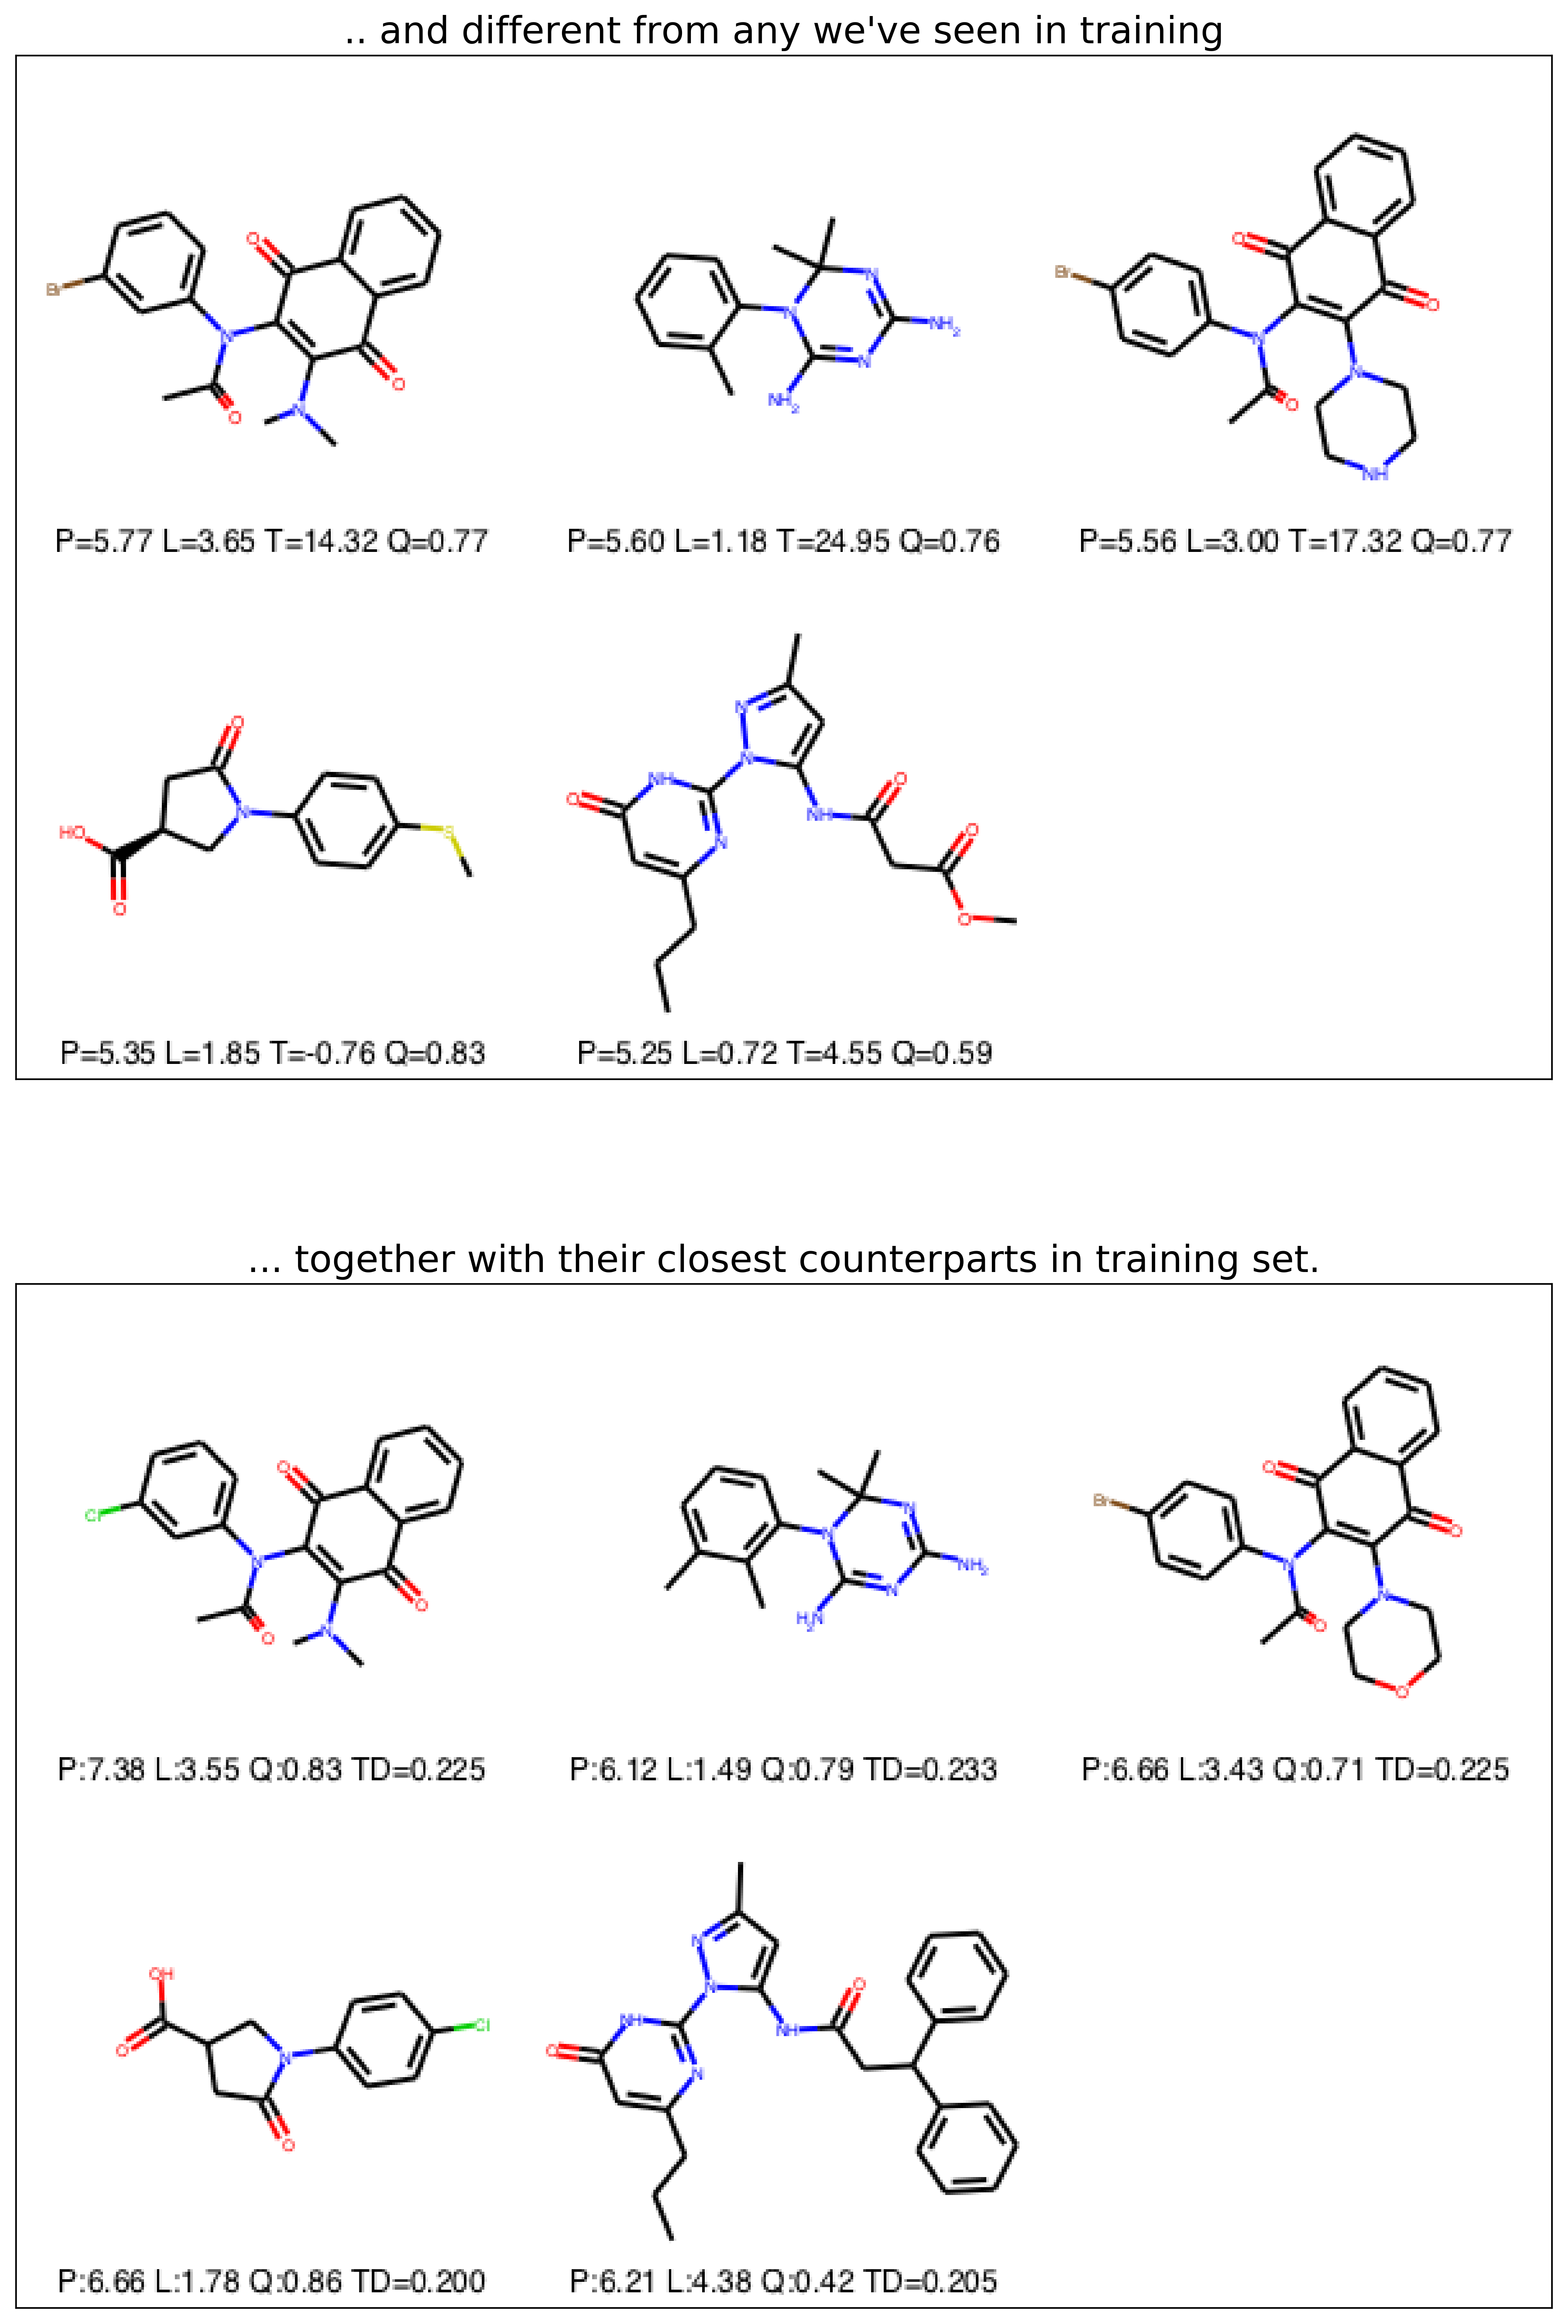

In [93]:
# Figure pot_hist in the paper.
def get_neighbour_labels(vals, min_dists):
    labels = []
    for (i, v) in enumerate(vals):
        it = full_df.loc[v]
        lbl = 'P:%.2f L:%.2f Q:%.2f %s' % (it.POTENCY, it.crippen, it.qed, min_dists[i])
        labels.append(lbl)
        pass
    return labels

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title(".. and different from any we've seen in training")
neighbours, mds = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2, draw=False)
nl = get_neighbour_labels(neighbours, mds)
plt.subplot(212)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in neighbours],legends=nl)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('... together with their closest counterparts in training set.')
savefig('figures/fig6.png')

In [94]:
pwd

u'/Users/oliverwatson/evartech/moarf/notebooks'

### Bias 2.

In [95]:
tc_dists = cdist(fpa, fpa, metric='jaccard') + np.diag(np.ones(len(fpa)) * np.nan)
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')
df0 = pd.read_pickle(std_files[0])
idcs = np.random.choice(np.arange(df0.shape[0]), 10000)
fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])
r_dists = cdist(fpr, fpr, metric='jaccard') + np.diag(np.ones(len(fpr)) * np.nan)
tcr_dists = cdist(fpr, fpa, metric='jaccard')
mal_hist= np.histogram(tc_dists[~np.isnan(tc_dists)], density=True, bins=7)
mr_hist = np.histogram(tcr_dists[~np.isnan(tcr_dists)], density=True, bins=7)

# magic number - but justified by looking at the bottom plot below.

In [ ]:
mtc_dists = np.nanmin(tc_dists, axis=1)

In [ ]:
mrtcr_dists = np.nanmin(cdist(fpr, fpa, metric='jaccard'), axis=1)

In [ ]:
_ = plt.hist(mtc_dists, density=True, bins=20)
plt.grid(True)
_ = plt.title('Minimum distances between a point in the Malaria dataset and other points in the dataset')

In [ ]:
_ = plt.hist(mrtcr_dists, density=True, bins=20)
plt.grid(True)
_ = plt.title('Minimum distances between a random compound and active compounds')

In [160]:
h1 = np.histogram(mtc_dists, bins=10)

In [161]:
h2 = np.histogram(mrtcr_dists, bins=10)

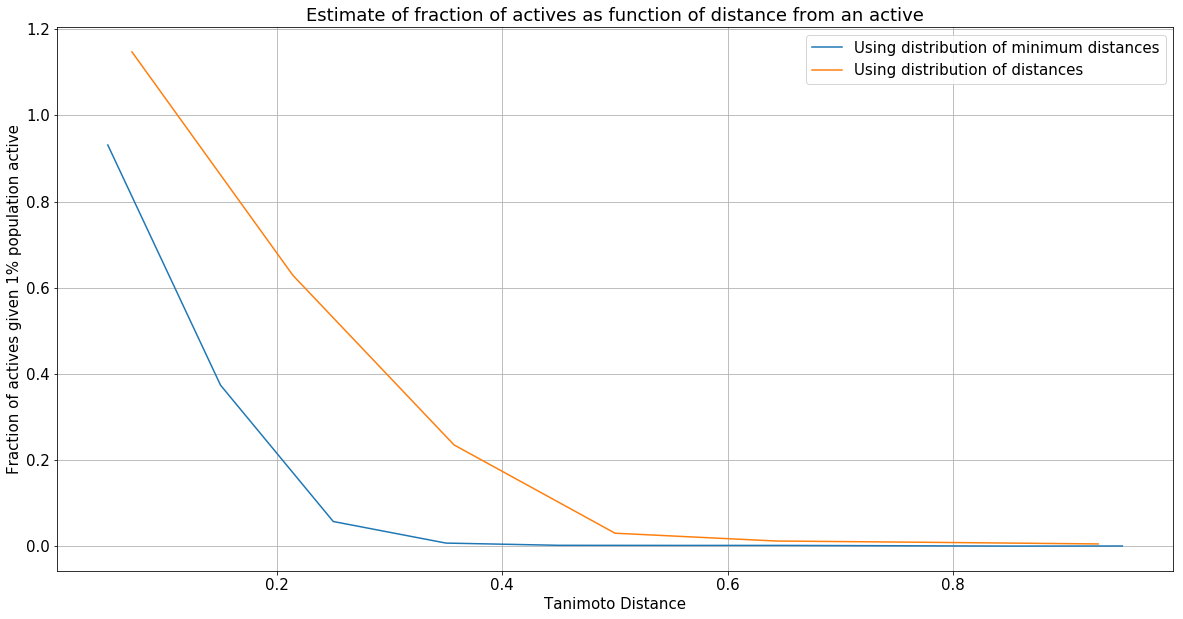

In [165]:
plt.plot((h1[1][1:] + h1[1][:-1])*.5 , (h1[0] / (2*num_inactive_per_active * h2[0] + 1.)), 
         label='Using distribution of minimum distances')
plt.plot(x_axis, mal_hist[0]/(num_inactive_per_active*mr_hist[0]), label='Using distribution of distances')
plt.grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given 1% population active')
plt.legend(loc='best')
_ = plt.title('Estimate of fraction of actives as function of distance from an active')